In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import os
import sys
import json
import pickle
import copy
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from scipy.stats import ttest_ind, pearsonr
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as hierarchy
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_validate, KFold, GridSearchCV, RandomizedSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import f1_score, accuracy_score

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
size = lambda obj: '%s MB' % np.round(sys.getsizeof(obj) / (1024**2), 1)

In [4]:
import acda
from acda.method_functions import *
from acda.plot_functions import *
from acda.general_functions import *

In [10]:
help(acda)

Help on package acda:

NAME
    acda

PACKAGE CONTENTS
    __main__
    _version
    general_functions
    method_functions
    plot_functions

VERSION
    0.0.4

FILE
    c:\users\domans\anaconda3\lib\site-packages\acda-0.0.4-py3.8.egg\acda\__init__.py




In [6]:
from preparation_functions import *
from additional_plotting_functions import *

In [7]:
projectDir = 'c:/Projects/A_PDX_drug_synergy/'
dirGDSCsensitivity = projectDir + 'data/fromGDSC/'
dirGraceCuratedSynergy = projectDir + 'data/curated synergy Grace/'
dirFromSanger = projectDir + 'data/fromSanger/' # https://cellmodelpassports.sanger.ac.uk/downloads

In [10]:
# GDSC2_models = df_drug_sensitivity_GDSC2.reset_index()['MODEL'].unique()
# # df_drug_sensitivity_GDSC2.reset_index().to_csv(sdatadir + 'GDSC2_drug_sensitivity.csv.gz', index=False)
# # se_drug_synergy_Narayan.to_frame().reset_index().to_csv(sdatadir + 'CDA_synergy_pairs.csv.gz', index=False)
# # se_tissue_annotation_GDSC.loc[se_tissue_annotation_GDSC.index.isin(GDSC2_models)].to_frame().reset_index().to_csv(sdatadir + 'GDSC2_tissue_annotation.csv.gz', index=False)
# # se_drug_targets_GDSC.to_frame().reset_index().to_csv(sdatadir + 'GDSC2_drug_targets.csv.gz', index=False)
# # se_models_mutations_GDSC.apply(list).loc[se_models_mutations_GDSC.index.isin(GDSC2_models)].to_frame().reset_index().to_csv(sdatadir + 'GDSC2_model_mutations.csv.gz', index=False)

In [9]:
sdatadir = '../docs/examples/data/'
df_drug_sensitivity_GDSC2 = pd.read_csv(sdatadir + 'GDSC2_drug_sensitivity.csv.gz').set_index(['MODEL', 'DRUG'])
se_drug_synergy_CDA = pd.read_csv(sdatadir + 'CDA_synergy_pairs.csv.gz').set_index(['MODEL', 'DRUG1', 'DRUG2'])['SYNERGY_SCORE']
se_tissue_annotation_GDSC2 = pd.read_csv(sdatadir + 'GDSC2_tissue_annotation.csv.gz').set_index(['MODEL'])['TISSUE']
se_drug_targets_GDSC2 = pd.read_csv(sdatadir + 'GDSC2_drug_targets.csv.gz').set_index(['DRUG'])['TARGETS']
se_models_mutations_GDSC2 = pd.read_csv(sdatadir + 'GDSC2_model_mutations.csv.gz').set_index(['MODEL'])['MUTATIONS']

# Sensitivity

In [11]:
#               LNIC50         H       EINF
# MODEL DRUG                               
# 22RV1 AKT  -1.128191  4.117612  65.593002
#       AR    0.551742  0.234400  88.396987
#       AR_1  1.544170  2.815893  42.790641

In [13]:
df_drug_sensitivity_GDSC1 = prepGDSC('GDSC1', dirGDSCsensitivity)
print(df_drug_sensitivity_GDSC1.shape)

(292849, 2)


In [14]:
df_drug_sensitivity_GDSC2 = prepGDSC('GDSC2', dirGDSCsensitivity)
df_drug_sensitivity_GDSC2
# print(df_drug_sensitivity_GDSC2.shape)

LNIC50       AUC
MODEL DRUG                              
22RV1 5-Fluorouracil  2.478859  0.778340
      ABT737          3.748055  0.924353
      AGI-5198        5.893052  0.977997
      AGI-6780        3.901068  0.930359
      AMG-319         6.069160  0.980222
...                        ...       ...
huH-1 Wee1 Inhibitor  3.319654  0.888068
      Wnt-C59         3.335262  0.888855
      XAV939          4.645248  0.940572
      YK-4-279        3.772343  0.875391
      Zoledronate     4.553951  0.972963

[131108 rows x 2 columns]

In [15]:
df_drug_sensitivity_GDSC = pd.concat([df_drug_sensitivity_GDSC1, df_drug_sensitivity_GDSC2], axis=0).groupby(level=[0, 1]).mean()
print(df_drug_sensitivity_GDSC.shape)

(376632, 2)


In [16]:
df_drug_sensitivity_GDSC2.reset_index()['DRUG'].unique().shape

(192,)

# Synergy

In [17]:
# MODEL  DRUG1  DRUG2
# 22RV1  akt    ar        0.190
#               ar_1      6.415
#               bcl2    -54.700

In [19]:
# 240 drugs * 109 models = 437 unique pairs
se_drug_synergy_Narayan = prepNarayanSynergy(dirGraceCuratedSynergy + 'edited_41467_2020_16735_MOESM5_ESM.xlsx')
print(se_drug_synergy_Narayan.shape)

(874,)


In [20]:
se_drug_synergy_Narayan.to_csv('Supplementary Table 5.csv')

# Tissue annotation

In [23]:
# MODEL
# 1181N1     Central Nervous System
# 1205Lu                       Skin
# 1273-99               Soft Tissue

In [25]:
se_tissue_annotation_GDSC = getTissueAnnotationGDSC(dirFromSanger + 'model_list_20210719.csv')
print(se_tissue_annotation_GDSC.value_counts().to_dict())
print(se_tissue_annotation_GDSC.shape)

{'Haematopoietic and Lymphoid': 370, 'Lung': 293, 'Skin': 131, 'Large Intestine': 123, 'Central Nervous System': 118, 'Head and Neck': 95, 'Ovary': 85, 'Bone': 82, 'Breast': 82, 'Pancreas': 74, 'Esophagus': 74, 'Soft Tissue': 73, 'Kidney': 63, 'Peripheral Nervous System': 48, 'Stomach': 46, 'Bladder': 40, 'Biliary Tract': 39, 'Cervix': 32, 'Endometrium': 30, 'Liver': 29, 'Thyroid': 21, 'Prostate': 15, 'Eye': 11, 'Uterus': 8, 'Unknown': 7, 'Testis': 5, 'Placenta': 4, 'Vulva': 3, 'Small Intestine': 2, 'Adrenal Gland': 1}
(2004,)


In [26]:
df_full_models_metafata = pd.read_csv(dirFromSanger + 'model_list_20210719.csv', index_col='model_name')[['tissue', 'tissue_status', 'cancer_type', 'cancer_type_detail']]
df_full_models_metafata

,tissue,tissue_status,cancer_type,cancer_type_detail
model_name,,,,
HCM-SANG-0314-C15,Esophagus,Tumour,Esophageal Carcinoma,Esophageal Adenocarcinoma
HCM-SANG-0272-C20,Large Intestine,Tumour,Colorectal Carcinoma,Rectal Adenocarcinoma
HCM-SANG-0310-C15,Esophagus,Tumour,Esophageal Carcinoma,Esophageal Adenocarcinoma
HLF,Liver,Tumour,Hepatocellular Carcinoma,Hepatocellular Carcinoma
TE-7,Esophagus,Unknown,Esophageal Squamous Cell Carcinoma,Esophageal Squamous Cell Carcinoma
...,...,...,...,...
HCM-SANG-0519-C20,Large Intestine,Tumour,Colorectal Carcinoma,Rectal Mucinous Adenocarcinoma
HCM-SANG-0534-C18,Large Intestine,Tumour,Colorectal Carcinoma,Colon Adenocarcinoma
HCM-SANG-0547-C25,Pancreas,Tumour,Pancreatic Carcinoma,Pancreatic Ductal Adenocarcinoma


# Models mutations

In [27]:
# MODEL
# 22RV1    [A1CF, A1CF_ENST00000282641, A1CF_ENST00000373...
# 647-V    [A2ML1, AASDH, AASDH_ENST00000502617, AASS, AB...
# A549     [AATK, AATK_ENST00000326724, ABCA9, ABCB1, ABC...

In [29]:
se_models_mutations_GDSC = prepMutationsGDSC(dirFromSanger + 'mutations_20191101.csv')
print(se_models_mutations_GDSC.shape)

(1032,)


# Drug targets

In [30]:
# DRUG
# (5Z)-7-Oxozeaenol                        [MAP3K7]
# 5-Fluorouracil       [Antimetabolite (DNA & RNA)]
# A-443654                       [AKT1, AKT2, AKT3]

In [31]:
se_drug_targets_GDSC = prepDrugTargetsGDSC(dirGraceCuratedSynergy + 'screened_compunds_updated.xlsx')  # 442 drugs
print(se_drug_targets_GDSC.apply(len).value_counts().sort_index().to_dict())
print(se_drug_targets_GDSC.shape)

{1: 245, 2: 91, 3: 48, 4: 16, 5: 9, 6: 5, 7: 8, 8: 3, 9: 1, 10: 2, 11: 5, 12: 2, 14: 1, 16: 1, 18: 2, 23: 1, 31: 1, 39: 1}
(442,)


# Prepare values for regression or classifier

### CDA Regression model per tissue
Learn about synergy for the different drug pairs in different cell lines of a selected tissue.<br>
Transter this knowledge to predict synergy for a new cell line and another drug pair (of the same tissue!).<br>
$logit(\Theta_{ijk}) = a_1 + a_2*T_{ijk} + a_3*C_{ij} + a_4*S_{ik} + a_5*S_{jk}$<br>
<br>
Need to explore goodness of fit (Chi-square goodness of fit tests and deviance) with and without some of the terms.
As compared to random?

Cell line tissue: seTissues <br>
Target information: dfTa_k(ij) = dfT_ki | dfT_kj <br>
Cophenetic distance: dfC_ij <br>
Sensitivity to drug i: dfS_ki <br>
Sensitivity to drug j: dfS_kj <br>
Known synergy between drugs i and j: dfKS_(ij)

# Prep GDSC sets

In [194]:
dfTas_GDSC1_bladder = makeCDAformattedData('Bladder', se_drug_synergy_Narayan, se_tissue_annotation_GDSC, df_drug_sensitivity_GDSC1, se_models_mutations_GDSC, se_drug_targets_GDSC, 'GDSC1')
dfTas_GDSC2_bladder = makeCDAformattedData('Bladder', se_drug_synergy_Narayan, se_tissue_annotation_GDSC, df_drug_sensitivity_GDSC2, se_models_mutations_GDSC, se_drug_targets_GDSC, 'GDSC2')
dfTas_GDSC_bladder = makeCDAformattedData('Bladder', se_drug_synergy_Narayan, se_tissue_annotation_GDSC, df_drug_sensitivity_GDSC, se_models_mutations_GDSC, se_drug_targets_GDSC, 'GDSC')

Loading from cache...
979 cell lines, 117649 drug pairs
Synergy pairs in:	 874
Synergy pairs out:	 208
Data size: 115178371
0 1 2 3 4 5 6 7 8 9 10 11 
With known synergy: 38
With unknown synergy: 2235293
Loading from cache...
803 cell lines, 34969 drug pairs
Synergy pairs in:	 874
Synergy pairs out:	 134
Data size: 28080107
0 1 2 
With known synergy: 8
With unknown synergy: 629434
Loading from cache...
980 cell lines, 195364 drug pairs
Synergy pairs in:	 874
Synergy pairs out:	 258
Data size: 191456720
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
With known synergy: 40
With unknown synergy: 3711876


In [195]:
dfTas_GDSC1_breast = makeCDAformattedData('Breast', se_drug_synergy_Narayan, se_tissue_annotation_GDSC, df_drug_sensitivity_GDSC1, se_models_mutations_GDSC, se_drug_targets_GDSC, 'GDSC1')
dfTas_GDSC2_breast = makeCDAformattedData('Breast', se_drug_synergy_Narayan, se_tissue_annotation_GDSC, df_drug_sensitivity_GDSC2, se_models_mutations_GDSC, se_drug_targets_GDSC, 'GDSC2')
dfTas_GDSC_breast = makeCDAformattedData('Breast', se_drug_synergy_Narayan, se_tissue_annotation_GDSC, df_drug_sensitivity_GDSC, se_models_mutations_GDSC, se_drug_targets_GDSC, 'GDSC')

Loading from cache...
979 cell lines, 117649 drug pairs
Synergy pairs in:	 874
Synergy pairs out:	 208
Data size: 115178371
0 1 2 3 4 5 6 7 8 9 10 11 
With known synergy: 100
With unknown synergy: 6117648
Loading from cache...
803 cell lines, 34969 drug pairs
Synergy pairs in:	 874
Synergy pairs out:	 134
Data size: 28080107
0 1 2 
With known synergy: 74
With unknown synergy: 1783345
Loading from cache...
980 cell lines, 195364 drug pairs
Synergy pairs in:	 874
Synergy pairs out:	 258
Data size: 191456720
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
With known synergy: 122
With unknown synergy: 10158806


# Train and test on GDSC1, GDSC2 and GDSC Bladder

In [42]:
df_GDSC_bladder = MonteCarloCrossValidation(dfTas_GDSC_bladder, sample_non_synergy=True)
df_GDSC_bladder[0]

0

All pairs:		 3711916
Pairs with missing:	 666190
All with known pairs:	 115
Sampling training pairs
Training-testing pairs:	 79
Validation pairs:	 36
Prediction pairs:	 3045611

 ACDA:
On self:		 0.9475
Validation data:	 0.45

 CDA:
On self:		 0.46837
Validation data:	 0.503

 EN:
On self:		 0.81324
Validation data:	 0.778

 EN-ACDA:
On self:		 0.96491
Validation data:	 0.794
1

All pairs:		 3711916
Pairs with missing:	 666190
All with known pairs:	 110
Sampling training pairs
Training-testing pairs:	 69
Validation pairs:	 41
Prediction pairs:	 3045616

 ACDA:
On self:		 0.95046
Validation data:	 0.466

 CDA:
On self:		 0.55411
Validation data:	 0.5

 EN:
On self:		 0.99971
Validation data:	 0.664

 EN-ACDA:
On self:		 0.99849
Validation data:	 0.67
2

All pairs:		 3711916
Pairs with missing:	 666190
All with known pairs:	 114
Sampling training pairs
Training-testing pairs:	 78
Validation pairs:	 36
Prediction pairs:	 3045612

 ACDA:
On self:		 0.96465
Validation data:	 0.647

 CDA:

,mean,sem
ACDA,0.518,0.045
CDA,0.461,0.034
EN,0.766,0.056
EN-ACDA,0.802,0.040


In [40]:
df_GDSC1_bladder = MonteCarloCrossValidation(dfTas_GDSC1_bladder, sample_non_synergy=True)
df_GDSC1_bladder[0]

0

All pairs:		 2235331
Pairs with missing:	 508781
All with known pairs:	 97
Sampling training pairs
Training-testing pairs:	 66
Validation pairs:	 31
Prediction pairs:	 1726453

 ACDA:
On self:		 0.96787
Validation data:	 0.472

 CDA:
On self:		 0.69203
Validation data:	 0.443

 EN:
On self:		 1.0
Validation data:	 0.748

 EN-ACDA:
On self:		 0.99951
Validation data:	 0.737
1

All pairs:		 2235331
Pairs with missing:	 508781
All with known pairs:	 99
Sampling training pairs
Training-testing pairs:	 63
Validation pairs:	 36
Prediction pairs:	 1726451

 ACDA:
On self:		 0.93787
Validation data:	 0.88

 CDA:
On self:		 0.56291
Validation data:	 0.805

 EN:
On self:		 0.99715
Validation data:	 0.988

 EN-ACDA:
On self:		 0.99656
Validation data:	 0.988
2

All pairs:		 2235331
Pairs with missing:	 508781
All with known pairs:	 92
Sampling training pairs
Training-testing pairs:	 61
Validation pairs:	 31
Prediction pairs:	 1726458

 ACDA:
On self:		 0.96449
Validation data:	 0.656

 CDA:
On

,mean,sem
ACDA,0.686,0.051
CDA,0.624,0.051
EN,0.917,0.046
EN-ACDA,0.912,0.046


In [41]:
df_GDSC2_bladder = MonteCarloCrossValidation(dfTas_GDSC2_bladder, sample_non_synergy=True)
df_GDSC2_bladder[0]

0

All pairs:		 629442
Pairs with missing:	 147206
All with known pairs:	 82
Sampling training pairs
Training-testing pairs:	 54
Validation pairs:	 28
Prediction pairs:	 482154

 ACDA:
On self:		 0.92713
Validation data:	 0.606

 CDA:
On self:		 0.32378
Validation data:	 0.379

 EN:
On self:		 0.97734
Validation data:	 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



On self:		 0.94733
Validation data:	 0.487
1

All pairs:		 629442
Pairs with missing:	 147206
All with known pairs:	 85
Sampling training pairs
Training-testing pairs:	 56
Validation pairs:	 29
Prediction pairs:	 482151

 ACDA:
On self:		 0.90521
Validation data:	 0.588

 CDA:
On self:		 0.37003
Validation data:	 0.386

 EN:
On self:		 0.61464
Validation data:	 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



On self:		 0.94092
Validation data:	 0.609
2

All pairs:		 629442
Pairs with missing:	 147206
All with known pairs:	 84
Sampling training pairs
Training-testing pairs:	 56
Validation pairs:	 28
Prediction pairs:	 482152

 ACDA:
On self:		 0.93812
Validation data:	 nan

 CDA:
On self:		 0.45565
Validation data:	 nan

 EN:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



On self:		 0.71931
Validation data:	 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



On self:		 0.94079
Validation data:	 nan
3

All pairs:		 629442
Pairs with missing:	 147206
All with known pairs:	 84
Sampling training pairs
Training-testing pairs:	 54
Validation pairs:	 30
Prediction pairs:	 482152

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



On self:		 nan
Validation data:	 nan

 CDA:
On self:		 nan
Validation data:	 nan

 EN:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



On self:		 nan
Validation data:	 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



On self:		 nan
Validation data:	 nan
4

All pairs:		 629442
Pairs with missing:	 147206
All with known pairs:	 89
Sampling training pairs
Training-testing pairs:	 58
Validation pairs:	 31
Prediction pairs:	 482147

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



On self:		 nan
Validation data:	 nan

 CDA:
On self:		 nan
Validation data:	 nan

 EN:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



On self:		 nan
Validation data:	 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



On self:		 nan
Validation data:	 nan
5

All pairs:		 629442
Pairs with missing:	 147206
All with known pairs:	 79
Sampling training pairs
Training-testing pairs:	 52
Validation pairs:	 27
Prediction pairs:	 482157

 ACDA:
On self:		 0.94665
Validation data:	 0.67

 CDA:
On self:		 0.32498
Validation data:	 0.397

 EN:
On self:		 0.69282
Validation data:	 -0.1

 EN-ACDA:
On self:		 0.96831
Validation data:	 0.252
6

All pairs:		 629442
Pairs with missing:	 147206
All with known pairs:	 80
Sampling training pairs
Training-testing pairs:	 53
Validation pairs:	 27
Prediction pairs:	 482156

 ACDA:
On self:		 0.87805
Validation data:	 0.627

 CDA:
On self:		 0.44762
Validation data:	 0.458

 EN:
On self:		 0.95943
Validation data:	 -0.08

 EN-ACDA:
On self:		 0.94158
Validation data:	 0.126
7

All pairs:		 629442
Pairs with missing:	 147206
All with known pairs:	 75
Sampling training pairs
Training-testing pairs:	 49
Validation pairs:	 26
Prediction pairs:	 482161

 ACDA:
On self:		 0.99872

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



On self:		 0.96902
Validation data:	 0.832
8

All pairs:		 629442
Pairs with missing:	 147206
All with known pairs:	 79
Sampling training pairs
Training-testing pairs:	 53
Validation pairs:	 26
Prediction pairs:	 482157

 ACDA:
On self:		 0.96233
Validation data:	 nan

 CDA:
On self:		 0.51274
Validation data:	 nan

 EN:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



On self:		 0.84603
Validation data:	 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



On self:		 0.96934
Validation data:	 nan
9

All pairs:		 629442
Pairs with missing:	 147206
All with known pairs:	 87
Sampling training pairs
Training-testing pairs:	 56
Validation pairs:	 31
Prediction pairs:	 482149

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



On self:		 nan
Validation data:	 nan

 CDA:
On self:		 nan
Validation data:	 nan

 EN:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



On self:		 nan
Validation data:	 nan

 EN-ACDA:
On self:		 nan
Validation data:	 nan


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



,mean,sem
ACDA,0.667,0.046
CDA,0.427,0.026
EN,-0.090,0.010
EN-ACDA,0.461,0.126


# Train and test on GDSC1, GDSC2 and GDSC Breast

In [45]:
df_GDSC_breast = MonteCarloCrossValidation(dfTas_GDSC_breast, sample_non_synergy=True)
df_GDSC_breast[0]

0

All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 191
Sampling training pairs
Training-testing pairs:	 131
Validation pairs:	 60
Prediction pairs:	 7955140

 ACDA:
On self:		 0.96735
Validation data:	 0.573

 CDA:
On self:		 0.62741
Validation data:	 0.48

 EN:
On self:		 0.94887
Validation data:	 0.938

 EN-ACDA:
On self:		 0.97512
Validation data:	 0.641
1

All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 192
Sampling training pairs
Training-testing pairs:	 127
Validation pairs:	 65
Prediction pairs:	 7955139

 ACDA:
On self:		 0.96005
Validation data:	 0.748

 CDA:
On self:		 0.46861
Validation data:	 0.704

 EN:
On self:		 0.93053
Validation data:	 0.635

 EN-ACDA:
On self:		 0.97078
Validation data:	 0.789
2

All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 189
Sampling training pairs
Training-testing pairs:	 125
Validation pairs:	 64
Prediction pairs:	 7955142

 ACDA:
On self:		 0.96027
Validation data:	

,mean,sem
ACDA,0.572,0.029
CDA,0.468,0.032
EN,0.792,0.039
EN-ACDA,0.661,0.025


In [43]:
df_GDSC1_breast = MonteCarloCrossValidation(dfTas_GDSC1_breast, sample_non_synergy=True)
df_GDSC1_breast[0]

0

All pairs:		 6117748
Pairs with missing:	 1598559
All with known pairs:	 119
Sampling training pairs
Training-testing pairs:	 80
Validation pairs:	 39
Prediction pairs:	 4519070

 ACDA:
On self:		 0.96541
Validation data:	 0.542

 CDA:
On self:		 0.59282
Validation data:	 0.58

 EN:
On self:		 0.96409
Validation data:	 0.658

 EN-ACDA:
On self:		 0.9682
Validation data:	 0.707
1

All pairs:		 6117748
Pairs with missing:	 1598559
All with known pairs:	 127
Sampling training pairs
Training-testing pairs:	 77
Validation pairs:	 50
Prediction pairs:	 4519062

 ACDA:
On self:		 0.96784
Validation data:	 0.53

 CDA:
On self:		 0.73361
Validation data:	 0.506

 EN:
On self:		 0.99278
Validation data:	 0.569

 EN-ACDA:
On self:		 0.98958
Validation data:	 0.655
2

All pairs:		 6117748
Pairs with missing:	 1598559
All with known pairs:	 126
Sampling training pairs
Training-testing pairs:	 88
Validation pairs:	 38
Prediction pairs:	 4519063

 ACDA:
On self:		 0.96111
Validation data:	 0.745



,mean,sem
ACDA,0.617,0.035
CDA,0.620,0.022
EN,0.687,0.026
EN-ACDA,0.714,0.021


In [44]:
df_GDSC2_breast = MonteCarloCrossValidation(dfTas_GDSC2_breast, sample_non_synergy=True)
df_GDSC2_breast[0]

0

All pairs:		 1783419
Pairs with missing:	 323190
All with known pairs:	 163
Sampling training pairs
Training-testing pairs:	 113
Validation pairs:	 50
Prediction pairs:	 1460066

 ACDA:
On self:		 0.9626
Validation data:	 0.531

 CDA:
On self:		 0.40442
Validation data:	 0.464

 EN:
On self:		 0.98538
Validation data:	 0.56

 EN-ACDA:
On self:		 0.97551
Validation data:	 0.681
1

All pairs:		 1783419
Pairs with missing:	 323190
All with known pairs:	 156
Sampling training pairs
Training-testing pairs:	 98
Validation pairs:	 58
Prediction pairs:	 1460073

 ACDA:
On self:		 0.9633
Validation data:	 0.498

 CDA:
On self:		 0.36016
Validation data:	 0.361

 EN:
On self:		 0.93964
Validation data:	 0.808

 EN-ACDA:
On self:		 0.9815
Validation data:	 0.695
2

All pairs:		 1783419
Pairs with missing:	 323190
All with known pairs:	 155
Sampling training pairs
Training-testing pairs:	 107
Validation pairs:	 48
Prediction pairs:	 1460074

 ACDA:
On self:		 0.96576
Validation data:	 0.474

 C

,mean,sem
ACDA,0.443,0.044
CDA,0.306,0.038
EN,0.676,0.045
EN-ACDA,0.673,0.029


# Hyperparameter tunung GDSC1 & GDSC2 cross train and validate

In [88]:
dfTas_copy = dfTas_GDSC1_breast.copy()
dfTas_copy.loc[dfTas_copy[dfTas_copy['SYNERGY_SCORE'].isna()].sample(100, random_state=0).index, 'SYNERGY_SCORE'] = 0.
dfTas_GDSC1 = dfTas_copy.loc[(~dfTas_copy['Cij'].isna()) & (~dfTas_copy['Sik'].isna()) & (~dfTas_copy['Sjk'].isna()) & (~dfTas_copy['SYNERGY_SCORE'].isna())]

In [89]:
dfTas_copy = dfTas_GDSC2_breast.copy()
dfTas_copy.loc[dfTas_copy[dfTas_copy['SYNERGY_SCORE'].isna()].sample(100, random_state=0).index, 'SYNERGY_SCORE'] = 0.
dfTas_GDSC2 = dfTas_copy.loc[(~dfTas_copy['Cij'].isna()) & (~dfTas_copy['Sik'].isna()) & (~dfTas_copy['Sjk'].isna()) & (~dfTas_copy['SYNERGY_SCORE'].isna())]

In [107]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    f1score = f1_score(test_labels, predictions)
    print('Accuracy = {:0.2f}%.'.format(100 * accuracy))
    print('F1 score = {:0.2f}%.'.format(100 * f1score))
    print('Pearson: = {:0.3f}'.format(pearsonr(test_labels, predictions)[0]))
    return accuracy

In [108]:
inSynergy1 = dfTas_GDSC1['SYNERGY_SCORE'].values.copy()
inData1 = dfTas_GDSC1[['Tijk', 'Cij', 'Sik', 'Sjk']].astype(float).copy()

inSynergy2 = dfTas_GDSC2['SYNERGY_SCORE'].values.copy()
inData2 = dfTas_GDSC2[['Tijk', 'Cij', 'Sik', 'Sjk']].astype(float).copy()

In [111]:
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

clf = RandomForestClassifier(random_state=0, max_depth=20, n_estimators=300)
rf_random1 = RandomizedSearchCV(estimator=clf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

In [115]:
rf_random2 = RandomizedSearchCV(estimator=clf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

In [112]:
rf_random1.fit(inData1, inSynergy1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(max_depth=20,
                                                    n_estimators=300,
                                                    random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]}

In [109]:
base_model = RandomForestClassifier(n_estimators=500, random_state=42)
base_model.fit(inData1, inSynergy1)
base_accuracy = evaluate(base_model, inData2, inSynergy2)

Accuracy = 63.19%.
F1 score = 53.12%.
Pearson: = 0.248


In [113]:
best_random1 = rf_random1.best_estimator_
random_accuracy1 = evaluate(best_random1, inData2, inSynergy2)

Accuracy = 61.35%.
F1 score = 51.16%.
Pearson: = 0.209


In [116]:
rf_random2.fit(inData2, inSynergy2)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(max_depth=20,
                                                    n_estimators=300,
                                                    random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]}

In [110]:
base_model = RandomForestClassifier(n_estimators=500, random_state=42)
base_model.fit(inData2, inSynergy2)
base_accuracy = evaluate(base_model, inData1, inSynergy1)

Accuracy = 68.91%.
F1 score = 68.91%.
Pearson: = 0.390


In [117]:
best_random2 = rf_random1.best_estimator_
random_accuracy2 = evaluate(best_random2, inData1, inSynergy1)

Accuracy = 89.92%.
F1 score = 88.89%.
Pearson: = 0.797


# Cross-training (without tuning)

In [170]:
res_GDSC1_GDSC2 = dict()
for i in range(10):
    print(i)
    
    dfTas_copy = dfTas_GDSC1_breast.copy()
    dfTas_copy.loc[dfTas_copy[dfTas_copy['SYNERGY_SCORE'].isna()].sample(100, random_state=i).index, 'SYNERGY_SCORE'] = 0.
    dfTas_GDSC1 = dfTas_copy.loc[(~dfTas_copy['Cij'].isna()) & (~dfTas_copy['Sik'].isna()) & (~dfTas_copy['Sjk'].isna()) & (~dfTas_copy['SYNERGY_SCORE'].isna())]
    print(dfTas_GDSC1.shape)
    
    dfTas_copy = dfTas_GDSC2_breast.copy()
    dfTas_copy.loc[dfTas_copy[dfTas_copy['SYNERGY_SCORE'].isna()].sample(100, random_state=i).index, 'SYNERGY_SCORE'] = 0.
    dfTas_GDSC2 = dfTas_copy.loc[(~dfTas_copy['Cij'].isna()) & (~dfTas_copy['Sik'].isna()) & (~dfTas_copy['Sjk'].isna()) & (~dfTas_copy['SYNERGY_SCORE'].isna())]
    print(dfTas_GDSC2.shape)
    
    print('\n', 'M:')
    res_GDSC1_GDSC2[('EN', i)] = testCase(dfTas_GDSC1, dfTas_GDSC2, encode=True, useAllFeatures=False, cv=3)
    print('\n', 'ACDA:')
    res_GDSC1_GDSC2[('ACDA', i)] = testCase(dfTas_GDSC1, dfTas_GDSC2, encode=False, useAllFeatures=False, cv=3)
    print('\n', 'CDA:')
    res_GDSC1_GDSC2[('CDA', i)] = testCase(dfTas_GDSC1, dfTas_GDSC2, encode=False, useAllFeatures=False, cv=3, clf=LogisticRegression(random_state=0))

0
(119, 5)
(163, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.97855
Cross-validation:	 mean=0.875 std=0.067
Validation data:	 0.57
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96339
Cross-validation:	 mean=0.587 std=0.109
Validation data:	 0.328
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.57497
Cross-validation:	 mean=0.575 std=0.086


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anacon

Validation data:	 0.252
ro normalized:		 nan
1


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(127, 5)
(156, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.98171
Cross-validation:	 mean=0.813 std=0.078
Validation data:	 0.541
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96879
Cross-validation:	 mean=0.599 std=0.060
Validation data:	 0.302
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.61093
Cross-validation:	 mean=0.625 std=0.064


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anacon

Validation data:	 0.26
ro normalized:		 nan
2


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(126, 5)
(155, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.95633
Cross-validation:	 mean=0.772 std=0.139
Validation data:	 0.6
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.967
Cross-validation:	 mean=0.649 std=0.041
Validation data:	 0.324
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.69167
Cross-validation:	 mean=0.625 std=0.053
Validation data:	

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


 0.263
ro normalized:		 nan
3


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(127, 5)
(152, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.94964
Cross-validation:	 mean=0.804 std=0.016
Validation data:	 0.612
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96921
Cross-validation:	 mean=0.642 std=0.072
Validation data:	 0.407
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.72625
Cross-validation:	 mean=0.697 std=0.040


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


Validation data:	 0.238
ro normalized:		 nan
4


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(127, 5)
(149, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.95649
Cross-validation:	 mean=0.769 std=0.053
Validation data:	 0.543
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96371
Cross-validation:	 mean=0.566 std=0.136
Validation data:	 0.322
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.67613
Cross-validation:	 mean=0.653 std=0.158
Validation data:	

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anacon

 0.202
ro normalized:		 nan
5


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(129, 5)
(157, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.9433
Cross-validation:	 mean=0.777 std=0.050
Validation data:	 0.562
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96935
Cross-validation:	 mean=0.654 std=0.082
Validation data:	 0.381
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.68052
Cross-validation:	 mean=0.676 std=0.091


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anacon

Validation data:	 0.294
ro normalized:		 nan
6


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(121, 5)
(161, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.96281
Cross-validation:	 mean=0.808 std=0.069
Validation data:	 0.53
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96173
Cross-validation:	 mean=0.603 std=0.071
Validation data:	 0.298
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.66465
Cross-validation:	 mean=0.641 std=0.157
Validation data:	

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


 0.162
ro normalized:		 nan
7


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(134, 5)
(156, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.96706
Cross-validation:	 mean=0.856 std=0.018
Validation data:	 0.532
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96675
Cross-validation:	 mean=0.677 std=0.009
Validation data:	 0.368
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.7352


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


Cross-validation:	 mean=0.722 std=0.053
Validation data:	 0.295
ro normalized:		 nan
8


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(126, 5)
(151, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.95292
Cross-validation:	 mean=0.739 std=0.064
Validation data:	 0.571
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96918
Cross-validation:	 mean=0.654 std=0.086
Validation data:	 0.38
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.74235
Cross-validation:	 mean=0.741 std=0.067


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


Validation data:	 0.246
ro normalized:		 nan
9


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(124, 5)
(153, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.94162
Cross-validation:	 mean=0.761 std=0.021
Validation data:	 0.558
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.9647
Cross-validation:	 mean=0.526 std=0.147
Validation data:	 0.248
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.67108


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


Cross-validation:	 mean=0.587 std=0.159
Validation data:	 0.223
ro normalized:		 nan


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


In [173]:
df = pd.DataFrame(res_GDSC1_GDSC2).T['val']
df = pd.concat([df.groupby(level=0).mean(), df.groupby(level=0).sem()], axis=1)
df

,val,val
ACDA,0.3358,0.015193
CDA,0.2435,0.012801
EN,0.5619,0.008712


In [174]:
res_GDSC2_GDSC1 = dict()
for i in range(10):
    print(i)
    
    dfTas_copy = dfTas_GDSC1_breast.copy()
    dfTas_copy.loc[dfTas_copy[dfTas_copy['SYNERGY_SCORE'].isna()].sample(100, random_state=i).index, 'SYNERGY_SCORE'] = 0.
    dfTas_GDSC1 = dfTas_copy.loc[(~dfTas_copy['Cij'].isna()) & (~dfTas_copy['Sik'].isna()) & (~dfTas_copy['Sjk'].isna()) & (~dfTas_copy['SYNERGY_SCORE'].isna())]
    print(dfTas_GDSC1.shape)
    
    dfTas_copy = dfTas_GDSC2_breast.copy()
    dfTas_copy.loc[dfTas_copy[dfTas_copy['SYNERGY_SCORE'].isna()].sample(100, random_state=i).index, 'SYNERGY_SCORE'] = 0.
    dfTas_GDSC2 = dfTas_copy.loc[(~dfTas_copy['Cij'].isna()) & (~dfTas_copy['Sik'].isna()) & (~dfTas_copy['Sjk'].isna()) & (~dfTas_copy['SYNERGY_SCORE'].isna())]
    print(dfTas_GDSC2.shape)
    
    print('\n', 'M:')
    res_GDSC2_GDSC1[('EN', i)] = testCase(dfTas_GDSC2, dfTas_GDSC1, encode=True, useAllFeatures=False, cv=3)
    print('\n', 'ACDA:')
    res_GDSC2_GDSC1[('ACDA', i)] = testCase(dfTas_GDSC2, dfTas_GDSC1, encode=False, useAllFeatures=False, cv=3)
    print('\n', 'CDA:')
    res_GDSC2_GDSC1[('CDA', i)] = testCase(dfTas_GDSC2, dfTas_GDSC1, encode=False, useAllFeatures=False, cv=3, clf=LogisticRegression(random_state=0))

0
(119, 5)
(163, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.96972
Cross-validation:	 mean=0.815 std=0.070
Validation data:	 0.79
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.97227
Cross-validation:	 mean=0.578 std=0.033
Validation data:	 0.415
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.3014
Cross-validation:	 mean=0.275 std=0.042


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anacon

Validation data:	 0.623
ro normalized:		 nan
1


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(127, 5)
(156, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.99468
Cross-validation:	 mean=0.914 std=0.039
Validation data:	 0.842
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.97138
Cross-validation:	 mean=0.550 std=0.093
Validation data:	 0.458
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.38211
Cross-validation:	 mean=0.313 std=0.096
Validation data:	 0.507


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anacon

ro normalized:		 nan
2
(126, 5)
(155, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.97947
Cross-validation:	 mean=0.834 std=0.091
Validation data:	 0.805
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.97109
Cross-validation:	 mean=0.543 std=0.128
Validation data:	 0.44
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.26091
Cross-validation:	 mean=0.280 std=0.108


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


Validation data:	 0.614
ro normalized:		 nan
3


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(127, 5)
(152, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.99023
Cross-validation:	 mean=0.873 std=0.036
Validation data:	 0.797
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96745
Cross-validation:	 mean=0.488 std=0.085
Validation data:	 0.442
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.27523
Cross-validation:	 mean=0.313 std=0.102


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


Validation data:	 0.584
ro normalized:		 nan
4


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(127, 5)
(149, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.99456
Cross-validation:	 mean=0.923 std=0.068
Validation data:	 0.848
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96892
Cross-validation:	 mean=0.562 std=0.076
Validation data:	 0.37
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.28939
Cross-validation:	 mean=0.185 std=0.138


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anacon

Validation data:	 0.64
ro normalized:		 nan
5


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(129, 5)
(157, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.98884
Cross-validation:	 mean=0.865 std=0.037
Validation data:	 0.798
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96546
Cross-validation:	 mean=0.406 std=0.029
Validation data:	 0.49
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.28188
Cross-validation:	 mean=0.330 std=0.091


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


Validation data:	 0.626
ro normalized:		 nan
6


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(121, 5)
(161, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.97407
Cross-validation:	 mean=0.817 std=0.080
Validation data:	 0.801
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96578
Cross-validation:	 mean=0.436 std=0.025
Validation data:	 0.33
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.20289
Cross-validation:	 mean=0.202 std=0.043


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


Validation data:	 0.648
ro normalized:		 nan
7


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(134, 5)
(156, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.9927
Cross-validation:	 mean=0.894 std=0.062
Validation data:	 0.789
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.97387
Cross-validation:	 mean=0.534 std=0.033
Validation data:	 0.551
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.33025
Cross-validation:	 mean=0.332 std=0.038


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


Validation data:	 0.616
ro normalized:		 nan
8


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(126, 5)
(151, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.97788
Cross-validation:	 mean=0.871 std=0.052
Validation data:	 0.808
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96568
Cross-validation:	 mean=0.527 std=0.065
Validation data:	 0.405
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.26083


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anacon

Cross-validation:	 mean=0.257 std=0.056
Validation data:	 0.68
ro normalized:		 nan
9


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(124, 5)
(153, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.96771
Cross-validation:	 mean=0.782 std=0.069
Validation data:	 0.811
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.97228
Cross-validation:	 mean=0.565 std=0.073
Validation data:	 0.37
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.26613


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


Cross-validation:	 mean=0.297 std=0.051
Validation data:	 0.644
ro normalized:		 nan


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


In [175]:
df = pd.DataFrame(res_GDSC2_GDSC1).T['val']
df = pd.concat([df.groupby(level=0).mean(), df.groupby(level=0).sem()], axis=1)
df

,val,val
ACDA,0.4271,0.020340
CDA,0.6182,0.014716
EN,0.8089,0.006430


In [179]:
res_GDSC_AZ = dict()
for i in range(10):
    print(i)
    
    dfTas_copy = dfTas_GDSC_breast.copy()
    dfTas_copy.loc[dfTas_copy[dfTas_copy['SYNERGY_SCORE'].isna()].sample(100, random_state=i).index, 'SYNERGY_SCORE'] = 0.
    dfTas_GDSC1 = dfTas_copy.loc[(~dfTas_copy['Cij'].isna()) & (~dfTas_copy['Sik'].isna()) & (~dfTas_copy['Sjk'].isna()) & (~dfTas_copy['SYNERGY_SCORE'].isna())]
    print(dfTas_GDSC.shape)
    
    dfTas_copy = dfTas_AZ_breast.copy()
    dfTas_copy.loc[dfTas_copy[dfTas_copy['SYNERGY_SCORE'].isna()].sample(100, random_state=i).index, 'SYNERGY_SCORE'] = 0.
    dfTas_AZ = dfTas_copy.loc[(~dfTas_copy['Cij'].isna()) & (~dfTas_copy['Sik'].isna()) & (~dfTas_copy['Sjk'].isna()) & (~dfTas_copy['SYNERGY_SCORE'].isna())]
    print(dfTas_AZ.shape)
    
    print('\n', 'M:')
    res_GDSC_AZ[('EN', i)] = testCase(dfTas_GDSC, dfTas_AZ, encode=True, useAllFeatures=False, cv=3)
    print('\n', 'ACDA:')
    res_GDSC_AZ[('ACDA', i)] = testCase(dfTas_GDSC, dfTas_AZ, encode=False, useAllFeatures=False, cv=3)
    print('\n', 'CDA:')
    res_GDSC_AZ[('CDA', i)] = testCase(dfTas_GDSC, dfTas_AZ, encode=False, useAllFeatures=False, cv=3, clf=LogisticRegression(random_state=0))

0
(192, 89)
(14749, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.77
Cross-validation:	 mean=0.664 std=0.050
Validation data:	 0.01
ro normalized:		 0.043

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.9614
Cross-validation:	 mean=0.604 std=0.101
Validation data:	 -0.025


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 0.124


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



 CDA:
LogisticRegression(random_state=0)
On self:		 0.48116
Cross-validation:	 mean=0.415 std=0.192
Validation data:	 -0.004


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 -0.156
1
(192, 89)
(14751, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.77
Cross-validation:	 mean=0.664 std=0.050
Validation data:	 0.01
ro normalized:		 0.043

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.9614
Cross-validation:	 mean=0.604 std=0.101
Validation data:	 -0.025


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 0.124


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



 CDA:
LogisticRegression(random_state=0)
On self:		 0.48116
Cross-validation:	 mean=0.415 std=0.192
Validation data:	 -0.004


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 -0.156


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


2
(192, 89)
(14749, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.77
Cross-validation:	 mean=0.664 std=0.050
Validation data:	 0.01
ro normalized:		 0.043

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.9614
Cross-validation:	 mean=0.604 std=0.101
Validation data:	 -0.025


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 0.124


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



 CDA:
LogisticRegression(random_state=0)
On self:		 0.48116
Cross-validation:	 mean=0.415 std=0.192
Validation data:	 -0.004


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 -0.156


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


3
(192, 89)
(14755, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.77
Cross-validation:	 mean=0.664 std=0.050
Validation data:	 0.01
ro normalized:		 0.043

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.9614
Cross-validation:	 mean=0.604 std=0.101
Validation data:	 -0.025


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 0.124


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



 CDA:
LogisticRegression(random_state=0)
On self:		 0.48116
Cross-validation:	 mean=0.415 std=0.192
Validation data:	 -0.004


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 -0.156


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


4
(192, 89)
(14748, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.77
Cross-validation:	 mean=0.664 std=0.050
Validation data:	 0.01
ro normalized:		 0.043

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.9614
Cross-validation:	 mean=0.604 std=0.101
Validation data:	 -0.025


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 0.124


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



 CDA:
LogisticRegression(random_state=0)
On self:		 0.48116
Cross-validation:	 mean=0.415 std=0.192
Validation data:	 -0.004


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 -0.156


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


5
(192, 89)
(14750, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.77
Cross-validation:	 mean=0.664 std=0.050
Validation data:	 0.01
ro normalized:		 0.043

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.9614
Cross-validation:	 mean=0.604 std=0.101
Validation data:	 -0.025


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 0.124


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



 CDA:
LogisticRegression(random_state=0)
On self:		 0.48116
Cross-validation:	 mean=0.415 std=0.192
Validation data:	 -0.004


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 -0.156


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


6
(192, 89)
(14751, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.77
Cross-validation:	 mean=0.664 std=0.050
Validation data:	 0.01
ro normalized:		 0.043

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.9614
Cross-validation:	 mean=0.604 std=0.101
Validation data:	 -0.025


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 0.124


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



 CDA:
LogisticRegression(random_state=0)
On self:		 0.48116
Cross-validation:	 mean=0.415 std=0.192
Validation data:	 -0.004


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 -0.156
7
(192, 89)
(14749, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.77
Cross-validation:	 mean=0.664 std=0.050
Validation data:	 0.01
ro normalized:		 0.043

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.9614
Cross-validation:	 mean=0.604 std=0.101
Validation data:	 -0.025


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 0.124


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



 CDA:
LogisticRegression(random_state=0)
On self:		 0.48116
Cross-validation:	 mean=0.415 std=0.192
Validation data:	 -0.004


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 -0.156


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


8
(192, 89)
(14751, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.77
Cross-validation:	 mean=0.664 std=0.050
Validation data:	 0.01
ro normalized:		 0.043

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.9614
Cross-validation:	 mean=0.604 std=0.101
Validation data:	 -0.025


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 0.124


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



 CDA:
LogisticRegression(random_state=0)
On self:		 0.48116
Cross-validation:	 mean=0.415 std=0.192
Validation data:	 -0.004


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 -0.156


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


9
(192, 89)
(14752, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.77
Cross-validation:	 mean=0.664 std=0.050
Validation data:	 0.01
ro normalized:		 0.043

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.9614
Cross-validation:	 mean=0.604 std=0.101
Validation data:	 -0.025


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 0.124


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



 CDA:
LogisticRegression(random_state=0)
On self:		 0.48116
Cross-validation:	 mean=0.415 std=0.192
Validation data:	 -0.004


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 -0.156


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [180]:
df = pd.DataFrame(res_GDSC_AZ).T['val']
df = pd.concat([df.groupby(level=0).mean(), df.groupby(level=0).sem()], axis=1)
df

,val,val
ACDA,-0.025,0.0
CDA,-0.004,0.0
EN,0.010,0.0


In [182]:
res_AZ_GDSC = dict()
for i in range(10):
    print(i)
    
    dfTas_copy = dfTas_GDSC_breast.copy()
    dfTas_copy.loc[dfTas_copy[dfTas_copy['SYNERGY_SCORE'].isna()].sample(100, random_state=i).index, 'SYNERGY_SCORE'] = 0.
    dfTas_GDSC1 = dfTas_copy.loc[(~dfTas_copy['Cij'].isna()) & (~dfTas_copy['Sik'].isna()) & (~dfTas_copy['Sjk'].isna()) & (~dfTas_copy['SYNERGY_SCORE'].isna())]
    print(dfTas_GDSC.shape)
    
    dfTas_copy = dfTas_AZ_breast.copy()
    dfTas_copy.loc[dfTas_copy[dfTas_copy['SYNERGY_SCORE'].isna()].sample(100, random_state=i).index, 'SYNERGY_SCORE'] = 0.
    dfTas_AZ = dfTas_copy.loc[(~dfTas_copy['Cij'].isna()) & (~dfTas_copy['Sik'].isna()) & (~dfTas_copy['Sjk'].isna()) & (~dfTas_copy['SYNERGY_SCORE'].isna())]
    print(dfTas_AZ.shape)
    
    print('\n', 'M:')
    res_AZ_GDSC[('EN', i)] = testCase(dfTas_AZ, dfTas_GDSC, encode=True, useAllFeatures=False, cv=3)
    print('\n', 'ACDA:')
    res_AZ_GDSC[('ACDA', i)] = testCase(dfTas_AZ, dfTas_GDSC, encode=False, useAllFeatures=False, cv=3)
#     print('\n', 'CDA:')
#     res_AZ_GDSC[('CDA', i)] = testCase(dfTas_AZ, dfTas_GDSC, encode=False, useAllFeatures=False, cv=3, clf=LogisticRegression(random_state=0))

0
(192, 89)
(14749, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.30836
Cross-validation:	 mean=0.305 std=0.026
Validation data:	 0.128
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.80885
Cross-validation:	 mean=0.251 std=0.041
Validation data:	 0.019
ro normalized:		 nan
1


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(192, 89)
(14751, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.30835
Cross-validation:	 mean=0.304 std=0.004
Validation data:	 0.126
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.809
Cross-validation:	 mean=0.263 std=0.038
Validation data:	 -0.002
ro normalized:		 nan
2


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(192, 89)
(14749, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.30838
Cross-validation:	 mean=0.305 std=0.026
Validation data:	 0.127
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.80879
Cross-validation:	 mean=0.252 std=0.039
Validation data:	 0.009
ro normalized:		 nan
3


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(192, 89)
(14755, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.30834
Cross-validation:	 mean=0.304 std=0.005
Validation data:	 0.127
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.80926
Cross-validation:	 mean=0.240 std=0.006
Validation data:	 0.005
ro normalized:		 nan
4


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(192, 89)
(14748, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.30837
Cross-validation:	 mean=0.305 std=0.024
Validation data:	 0.127
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.80884
Cross-validation:	 mean=0.243 std=0.019
Validation data:	 -0.002
ro normalized:		 nan
5


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(192, 89)
(14750, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.30836
Cross-validation:	 mean=0.304 std=0.004
Validation data:	 0.126
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.80869
Cross-validation:	 mean=0.263 std=0.039
Validation data:	 0.012
ro normalized:		 nan
6


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(192, 89)
(14751, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.30834
Cross-validation:	 mean=0.304 std=0.004
Validation data:	 0.125
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.80855
Cross-validation:	 mean=0.264 std=0.037
Validation data:	 -0.002
ro normalized:		 nan
7


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(192, 89)
(14749, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.30834
Cross-validation:	 mean=0.305 std=0.026
Validation data:	 0.127
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.80902
Cross-validation:	 mean=0.250 std=0.039
Validation data:	 -0.003
ro normalized:		 nan
8


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(192, 89)
(14751, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.30811
Cross-validation:	 mean=0.304 std=0.004
Validation data:	 0.127
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.80907
Cross-validation:	 mean=0.264 std=0.037
Validation data:	 0.019
ro normalized:		 nan
9


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(192, 89)
(14752, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.30837
Cross-validation:	 mean=0.305 std=0.003
Validation data:	 0.127
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.809
Cross-validation:	 mean=0.265 std=0.036
Validation data:	 0.025
ro normalized:		 nan


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


In [183]:
df = pd.DataFrame(res_AZ_GDSC).T['val']
df = pd.concat([df.groupby(level=0).mean(), df.groupby(level=0).sem()], axis=1)
df

,val,val
ACDA,0.0080,0.003296
EN,0.1267,0.000260


# PDXE

In [61]:
response_mapping = {'CR': 1, 'PR': 0.5, 'SD': -0.25, 'PD': -1, 'SD-->PD': -0.75, 'SD-->-->PD': -0.5, 'CR-->PD': 0.75, 'CR-->-->PD': 0.75, 'PR-->PD': 0.25, 'PR-->-->PD': 0.25}

df_PDXE = pd.read_csv('c:/Projects/A_PDX_drug_synergy/PDXE/df_resp_PDXE.csv.gz')
df_PDXE['Model'] = df_PDXE['Model'].str.strip()
df_PDXE['Treatment'] = df_PDXE['Treatment'].str.split('+').apply(lambda s: [v.strip() for v in s])
df_PDXE['Treatment target'] = df_PDXE['Treatment target'].str.split(',').apply(lambda s: [v.strip() for v in s])
df_PDXE = df_PDXE.drop(['Day_BestResponse', 'Day_BestAvgResponse', 'TimeToDouble', 'Day_Last'], axis=1)
df_PDXE = df_PDXE.drop(['BestResponse', 'BestAvgResponse'], axis=1)
df_PDXE['ResponseCategory'] = df_PDXE['ResponseCategory'].replace(response_mapping)

df_PDXE_mono = df_PDXE[df_PDXE['Treatment type']=='single'].drop('Treatment type', axis=1)
df_PDXE_mono['Treatment'] = df_PDXE_mono['Treatment'].apply(pd.Series)
df_PDXE_mono = df_PDXE_mono.loc[df_PDXE_mono['Treatment']!='untreated']
df_PDXE_mono['Treatment target'] = df_PDXE_mono['Treatment target'].apply(lambda s: ['FGFR2', 'FGFR4'] if s==['FGFR2/4'] else s)
df_PDXE_mono['Treatment target'] = df_PDXE_mono['Treatment target'].apply(lambda s: ['CDK4', 'CDK6'] if s==['CDK4', 'CDK6', 'CDK4/6'] else s)
df_PDXE_mono.columns = ['MODEL', 'DRUG', 'TARGETS', 'RESPONSE']

df_PDXE_combo = df_PDXE[df_PDXE['Treatment type']=='combo'].drop(['Treatment type', 'Treatment target'], axis=1)
df_PDXE_combo[['DRUG1', 'DRUG2', 'DRUG3']] = df_PDXE_combo['Treatment'].apply(pd.Series)
df_PDXE_combo = df_PDXE_combo.loc[df_PDXE_combo['DRUG3'].isna()].drop(['DRUG3', 'Treatment'], axis=1)
df_PDXE_combo = df_PDXE_combo.rename({'Model': 'MODEL', 'ResponseCategory': 'RESPONSE'}, axis=1).set_index(['MODEL', 'DRUG1', 'DRUG2'])['RESPONSE']
se_PDXE_synergy_pairs = df_PDXE_combo.copy()

df_PDXE_sensitivity = df_PDXE_mono.set_index(['MODEL', 'DRUG'])[['RESPONSE']]

se_PDXE_tissue_annotation = pd.read_csv('c:/Projects/A_PDX_drug_synergy/PDXE/df_tissue_PDXE.csv.gz', index_col=0)['0']
se_PDXE_tissue_annotation.index.name = 'MODEL'
se_PDXE_tissue_annotation.name = 'TISSUE'

df_PDXE_mut = pd.read_excel('c:/Projects/A_PDX_drug_synergy/PDXE/41591_2015_BFnm3954_MOESM10_ESM.xlsx', sheet_name='pdxe_mut_and_cn2', index_col=0) # 'Sample', 'Gene', 'Category'
se_PDXE_model_mutations = df_PDXE_mut['Gene'].groupby(level=0).unique()
se_PDXE_model_mutations.index.name = 'MODEL'
se_PDXE_model_mutations.name = 'MUTATIONS'
se_PDXE_model_mutations

se_PDXE_drug_targets = df_PDXE_mono.set_index('DRUG')['TARGETS']
se_PDXE_drug_targets = se_PDXE_drug_targets.loc[~se_PDXE_drug_targets.index.duplicated()]

se_PDXE_model_mutations = se_PDXE_model_mutations.reindex(se_PDXE_model_mutations.index.union(se_PDXE_tissue_annotation.index))
se_PDXE_model_mutations = se_PDXE_model_mutations.apply(lambda s: [] if s is np.nan else s)

In [64]:
df_PDXE['Model'].unique().shape

(281,)

In [125]:
dfTas_PDXE = makeCDAformattedData(None, 
                                  se_PDXE_synergy_pairs, 
                                  se_PDXE_tissue_annotation, 
                                  df_PDXE_sensitivity, 
                                  se_PDXE_model_mutations, 
                                  se_PDXE_drug_targets, 
                                  'PDXE', 
                                  sensitivity_metric='RESPONSE',
                                  lower=False)

Loading from cache...
253 cell lines, 1369 drug pairs
Synergy pairs in:	 1237
Synergy pairs out:	 1062
Data size: 346357
0 
With known synergy: 1062
With unknown synergy: 345295


In [121]:
# response_mapping
response_mapping_reverse = pd.Series(response_mapping).reset_index().set_index(0)['index'].groupby(level=0).unique().sort_index(ascending=False).apply(lambda s: s[0]).to_dict()
dfTas_PDXE['RESPONSE_CATEGORY'] = dfTas_PDXE['SYNERGY_SCORE'].replace(response_mapping_reverse)
df_temp = dfTas_PDXE.loc[~dfTas_PDXE['SYNERGY_SCORE'].isna()].dropna()
df_temp['RESPONSE_CATEGORY'].reset_index('TISSUE').value_counts().unstack('TISSUE').fillna(0).astype(int).sort_index()

TISSUE,GC,CRC,BRCA,CM,PDAC,NSCLC
RESPONSE_CATEGORY,,,,,,
CR,7,4,5,11,2,5
CR-->PD,3,0,0,10,0,1
PD,111,107,45,34,31,24
PR,16,16,12,6,8,5
PR-->PD,18,4,4,19,3,3
SD,40,21,14,4,15,2
SD-->-->PD,6,5,2,5,5,1
SD-->PD,46,51,34,28,32,17


In [112]:
PDXE_tissues = ['CRC', 'GC', 'PDAC', 'BRCA', 'NSCLC', 'CM']
df_PDXE_res = dict()
for tissue in PDXE_tissues:
    df_PDXE_res[tissue] = MonteCarloCrossValidation(dfTas_PDXE.xs(tissue, level='TISSUE', drop_level=False), factor=2/3)
df_PDXE_res = pd.DataFrame([df_PDXE_res[tissue][0].stack() for tissue in PDXE_tissues], index=PDXE_tissues)

0

All pairs:		 61605
Pairs with missing:	 54482
All with known pairs:	 208
Sampling training pairs
Training-testing pairs:	 138
Validation pairs:	 70
Prediction pairs:	 6915

 ACDA:
On self:		 0.66454
Validation data:	 0.462

 CDA:
On self:		 0.44222
Validation data:	 0.413

 EN:
On self:		 0.79848
Validation data:	 0.432

 EN-ACDA:
On self:		 0.9443
Validation data:	 0.588
1

All pairs:		 61605
Pairs with missing:	 54482
All with known pairs:	 208
Sampling training pairs
Training-testing pairs:	 138
Validation pairs:	 70
Prediction pairs:	 6915

 ACDA:
On self:		 0.664
Validation data:	 0.481

 CDA:
On self:		 0.43451
Validation data:	 0.44

 EN:
On self:		 0.79639
Validation data:	 0.511

 EN-ACDA:
On self:		 0.95484
Validation data:	 0.502
2

All pairs:		 61605
Pairs with missing:	 54482
All with known pairs:	 208
Sampling training pairs
Training-testing pairs:	 138
Validation pairs:	 70
Prediction pairs:	 6915

 ACDA:
On self:		 0.75127
Validation data:	 0.256

 CDA:
On self:		 0.

On self:		 0.67571
Validation data:	 0.307

 EN-ACDA:
On self:		 0.95793
Validation data:	 0.165
2

All pairs:		 57498
Pairs with missing:	 50779
All with known pairs:	 96
Sampling training pairs
Training-testing pairs:	 64
Validation pairs:	 32
Prediction pairs:	 6623

 ACDA:
On self:		 0.59831
Validation data:	 0.609

 CDA:
On self:		 0.47719
Validation data:	 0.614

 EN:
On self:		 0.66287
Validation data:	 0.08

 EN-ACDA:
On self:		 0.81895
Validation data:	 0.593
3

All pairs:		 57498
Pairs with missing:	 50779
All with known pairs:	 96
Sampling training pairs
Training-testing pairs:	 64
Validation pairs:	 32
Prediction pairs:	 6623

 ACDA:
On self:		 0.67508
Validation data:	 0.544

 CDA:
On self:		 0.60055
Validation data:	 0.45

 EN:
On self:		 0.7279
Validation data:	 -0.309

 EN-ACDA:
On self:		 0.84261
Validation data:	 0.337
4

All pairs:		 57498
Pairs with missing:	 50779
All with known pairs:	 96
Sampling training pairs
Training-testing pairs:	 64
Validation pairs:	 32
Pr

On self:		 0.91746
Validation data:	 0.459

 EN-ACDA:
On self:		 0.95954
Validation data:	 0.543
4

All pairs:		 39701
Pairs with missing:	 32339
All with known pairs:	 58
Sampling training pairs
Training-testing pairs:	 38
Validation pairs:	 20
Prediction pairs:	 7304

 ACDA:
On self:		 0.7604
Validation data:	 0.394

 CDA:
On self:		 0.4938
Validation data:	 0.607

 EN:
On self:		 0.92673
Validation data:	 0.541

 EN-ACDA:
On self:		 0.96419
Validation data:	 0.599
5

All pairs:		 39701
Pairs with missing:	 32339
All with known pairs:	 58
Sampling training pairs
Training-testing pairs:	 38
Validation pairs:	 20
Prediction pairs:	 7304

 ACDA:
On self:		 0.72731
Validation data:	 0.231

 CDA:
On self:		 0.43737
Validation data:	 0.717

 EN:
On self:		 0.88947
Validation data:	 0.499

 EN-ACDA:
On self:		 0.95533
Validation data:	 0.578
6

All pairs:		 39701
Pairs with missing:	 32339
All with known pairs:	 58
Sampling training pairs
Training-testing pairs:	 38
Validation pairs:	 20
Pr

In [113]:
df_PDXE_res.style.background_gradient(axis=1)

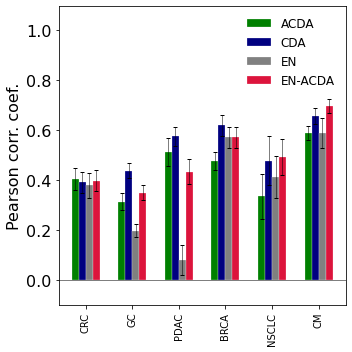

In [244]:
def makeBarplotPDXE(df_res_single, figsize=(5, 5), c=['green', 'navy', 'grey', 'crimson'], width=0.15, labelsAbove=False, saveName=None, dpi=300):

    oneax = None
    fig, ax = plt.subplots(figsize=figsize)
    for pos in np.arange(len(df_res_single)):
        df_temp = df_res_single.iloc[pos].unstack()
        bpos = np.array([-width*6/4, -width*2/4, width*2/4, width*6/4])
        bars = ax.bar(pos + bpos, df_temp['mean'].values, width, label=df_res_single.index[pos], yerr=df_temp['sem'].values, color=c, 
                      align='center', alpha=1.0, ecolor='black', capsize=2, edgecolor='w', linewidth=0.25)
        if oneax is None:
            oneax = bars

        if labelsAbove:
            t0 = ax.text(pos, df_temp['mean'].max() + 0.08, df_res_single.index.values[pos][0].replace('_', ' '), ha='center')
            t1 = ax.text(pos, df_temp['mean'].max() + 0.05, df_res_single.index.values[pos][1], ha='center')

            t0.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),path_effects.Normal()])
            t1.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),path_effects.Normal()])

    if not labelsAbove:
        ax.set_xticks(range(len(df_res_single)))
        #ax.set_xticklabels([v[0].replace('_', ' ').capitalize() + '\n' + v[1].replace('_', ' ') for v in df_res_single.index.values], rotation=90, va='top')
        ax.set_xticklabels(df_res_single.index.values, rotation=90, va='top')
    else:
        ax.set_xticks([])

    ax.set_ylabel('Pearson corr. coef.', fontsize=16)
    ax.axhline(0, color='k', linewidth=0.5)
    ax.legend(oneax, ['ACDA', 'CDA', 'EN', 'EN-ACDA'], frameon=False, loc='upper right', fontsize=12)
    ax.set_ylim([-0.1, 1.095])
    ax.tick_params(axis='y', labelsize=16)

    fig.tight_layout()
    
    if not saveName is None:
        fig.savefig(saveName, facecolor='w', dpi=dpi)
    
    return

makeBarplotPDXE(df_PDXE_res)

In [162]:
def plotHeatmapPredictedSynergy(dfC, Z, pvalues):

    fig, ax = plt.subplots(2, 2, figsize=(7, 7), gridspec_kw={'height_ratios':[1,3], 'width_ratios':[3,1]})

    origLineWidth = matplotlib.rcParams['lines.linewidth']
    matplotlib.rcParams['lines.linewidth'] = 0.5
    n_clusters = 10
    cmap = cm.gist_ncar(np.linspace(0, 0.5, n_clusters + 1))
    hierarchy.set_link_color_palette([matplotlib.colors.rgb2hex(rgb[:3]) for rgb in cmap])

    dendrogram(Z, ax=ax[1, 1], color_threshold = (Z[-n_clusters,2] + Z[-n_clusters + 1,2]) / 2, 
                   above_threshold_color='k', orientation='right', no_labels=True)
    D = dendrogram(Z, ax=ax[0, 0], color_threshold = (Z[-n_clusters,2] + Z[-n_clusters + 1,2]) / 2, 
                   above_threshold_color='k', orientation='top', no_labels=True)

    leaves = D['leaves']
    names = dfC.index[leaves]
    ax[1, 1].axis("off")
    ax[0, 0].axis("off")
    ax[1, 0].axis("off")

    se = pd.Series(index=pd.MultiIndex.from_tuples(pvalues), data=1)
    se = pd.concat([se, se.reorder_levels([0, 2, 1])])
    se = se.loc[~se.index.duplicated()]
    se = se.droplevel(0)
    se = se.groupby(level=[0, 1]).sum()
    se = se.loc[se.index.to_frame()[0] != se.index.to_frame()[1]]
    dfDr = se.unstack(0).fillna(0.).reindex(dfC.index, axis=0).reindex(dfC.index, axis=1).fillna(0.).astype(int)

    dfDr = dfDr.replace(0, np.nan)
    dfDr = dfDr.iloc[leaves[::-1], leaves]
    masked_M = np.ma.array(dfDr.values, mask=np.isnan(dfDr.values))

    #dfCc = dfC.iloc[leaves[::-1], leaves]
    #masked_M = np.ma.array(dfCc.values, mask=np.isnan(dfCc.values))
    cmap = copy.copy(plt.cm.bwr)
    cmap.set_bad('lightgrey')
    vmin, vmax = None, None

    im = ax[1, 0].imshow(masked_M, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax, interpolation='None', 
                   extent=(-0.5, masked_M.shape[0] - 0.5, masked_M.shape[1] - 0.5, -0.5))

    ax[0, 1].axis("off")
    clb = fig.colorbar(im, ax=ax[0, 1], fraction=0.5, shrink=0.85, orientation='horizontal', label='Count')
    clb.ax.tick_params(labelsize=10)

    plt.subplots_adjust(hspace=0.001)
    fig.tight_layout()

    hierarchy.set_link_color_palette(None)
    matplotlib.rcParams['lines.linewidth'] = origLineWidth

    return dfDr

In [156]:
CDA_features = ['Tijk', 'Cij', 'Sik', 'Sjk']
predictee = 'SYNERGY_SCORE'

dfTas = dfTas_PDXE.xs('BRCA', level='TISSUE', drop_level=False)
dfTas = dfTas.loc[dfTas.index.get_level_values('DRUG1')!=dfTas.index.get_level_values('DRUG2')]
dfTas = dfTas.loc[~dfTas[CDA_features].isna().any(axis=1)]
df_train_test = dfTas[~dfTas[predictee].isna()]
df_validate = dfTas[dfTas[predictee].isna()]

def predictByOneMethod(df_train_test, df_validate, encode=True, clf=None, name=None, excludeCDAfeatures=False):
    if encode:
        dfe_train_test = encodeNames(df_train_test)
        dfe_train_test = dfe_train_test[dfe_train_test.columns.intersection(encodeNames(df_validate).columns)]
        dfe_validate = encodeNames(df_validate).reindex(dfe_train_test.columns, axis=1).fillna(0.).astype(int)
        df_train_test.loc[:, dfe_train_test.columns] = dfe_train_test.values
        df_validate.loc[:, dfe_validate.columns] = dfe_validate.values
        
    features = df_train_test.columns[~df_train_test.columns.isin([predictee])]
    
    if excludeCDAfeatures:
        features = features.difference(CDA_features)
        
    print(df_train_test.shape, df_validate.shape, len(features))
    
    clf = fit_validate_predict(df_train_test[features].values, df_train_test[predictee].values, cv=None, clf=clf)
    se_predicted = pd.Series(index=df_validate.index, data=clf.predict(df_validate[features].values)).sort_index()
    se_predicted = se_predicted.sort_values(ascending=False)
    se_predicted.name = name
    return se_predicted

df_predicted = pd.concat([predictByOneMethod(df_train_test.copy(), df_validate.copy(), encode=False, clf=None, name='ACDA'),
                    predictByOneMethod(df_train_test.copy(), df_validate.copy(), encode=False, clf=LinearRegression(), name='CDA'),
                    predictByOneMethod(df_train_test.copy(), df_validate.copy(), encode=True, clf=None, name='EN', excludeCDAfeatures=True),
                    predictByOneMethod(df_train_test.copy(), df_validate.copy(), encode=True, clf=None, name='EN-ACDA')], axis=1)
df_predicted = df_predicted.sort_values(by='EN-ACDA', ascending=False) #.droplevel('TISSUE')
df_predicted

(116, 5) (9184, 5) 4
On self:		 0.80447
(116, 5) (9184, 5) 4
On self:		 0.65261
(116, 262) (9184, 262) 257
On self:		 0.94315
(116, 262) (9184, 262) 261
On self:		 0.97325


ACDA       CDA        EN  EN-ACDA
MODEL  DRUG1       DRUG2  TISSUE                                       
X-4567 CLR457      LJM716 BRCA    0.723783  0.844988  0.849000    0.821
       paclitaxel  LJM716 BRCA    0.723783  0.844159  0.849000    0.821
       BKM120      LJM716 BRCA    0.723783  0.844988  0.849000    0.821
       LLM871      LJM716 BRCA    0.723783  0.844159  0.849000    0.821
                   BGJ398 BRCA    0.691722  0.422167  0.843000    0.818
...                                    ...       ...       ...      ...
X-1298 LJM716      LFA102 BRCA   -0.948927 -0.851685 -0.999333   -1.000
                   LKA136 BRCA   -0.948927 -0.851685 -0.999333   -1.000
X-6047 trastuzumab LJM716 BRCA   -0.948927 -0.851685 -0.998000   -1.000
X-4949 trastuzumab LJM716 BRCA   -0.948927 -0.851685 -1.000000   -1.000
X-6047 LJM716      LFA102 BRCA   -0.948927 -0.851685 -0.998000   -1.000

[9184 rows x 4 columns]

In [157]:
df_predicted.to_csv('Supplementary Table 3.xlsx')

In [169]:
df_predicted.droplevel('TISSUE').head(20).to_csv('Top 20 Supplementary Table 3.xlsx') #.unstack('MODEL').reorder_levels([1,0], axis=1).T.sort_index()

paclitaxel LLM871 CLR457 BKM120 binimetinib


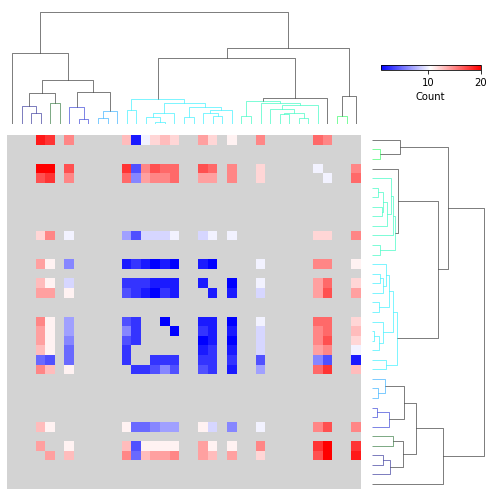

In [163]:
se_predicted = df_predicted['EN-ACDA']
dfC, dfS, Z = getDistanceAndSensitivityData(df_PDXE_sensitivity, method='cosine', sensitivity_metric='RESPONSE', lower=False)
dfDr = plotHeatmapPredictedSynergy(dfC, Z, se_predicted.loc[se_predicted>=-0.0].index.droplevel(-1).values)
print(dfDr.columns[3],dfDr.columns[4],dfDr.columns[32],dfDr.columns[33],dfDr.columns[36])
dfDr.to_csv('dfDr_BRCA_EN-ACDA.csv')

In [199]:
df = dfTas_PDXE.xs('BRCA', level='TISSUE', drop_level=False).dropna()
df = pd.Series(index=df.index.droplevel(['MODEL', 'TISSUE']), data=1)
df.groupby(level=[0,1]).count().sort_index()

DRUG1   DRUG2      
BYL719  LEE011         39
        LJM716         39
LJM716  trastuzumab    38
dtype: int64

# Load and tidy the DrugComb data

In [37]:
#tempfname = '../data/cacheDrugCombWithAllMono.pklz'
tempfname = '../data/cacheDrugComb.pklz'

if not os.path.isfile(tempfname):
    # Data was downloaded from "https://drugcomb.fimm.fi/jing/summary_v_1_5.csv"
    df_DC = pd.read_csv(projectDir + 'data/drugcomb_data_v1.5.csv.gz', index_col=0)
    df_DC = df_DC.set_index(['study_name', 'cell_line_name', 'drug_row', 'drug_col', 'tissue_name'])
    df_DC.index.names = ['STUDY', 'MODEL', 'DRUG1', 'DRUG2', 'TISSUE']

    # Remove entries which are duplicates
    df_DC = df_DC.sort_index(level='DRUG2', ascending=True)
    df_DC = df_DC.loc[~df_DC.index.duplicated(keep='first')]
    df_DC = df_DC.sort_index()

    # Remove entries where DRUG1 is equal to DRUG2
    df_DC = df_DC.loc[df_DC.index.to_frame()['DRUG1'] != df_DC.index.to_frame()['DRUG2']]

    # Remove entries with no combinations measures, i.e. monotherapy experiments
    df_DC = df_DC.loc[pd.MultiIndex.from_frame(df_DC.index.to_frame().dropna())]

    dfgp = getGeneToProteinNameAssociation()
    convertProteinNamesToGenes(df_DC['drug_row_target_name'], dfgp)
    convertProteinNamesToGenes(df_DC['drug_col_target_name'], dfgp)

    # Keep subset of the columns, rename selected, below is the list of "not selected" columns:
    # ['conc_row_unit', 'conc_col_unit', 'css_row', 'css_col', 'css_ri', 'S_sum', 'S_mean', 'S_max', 'drug_row_clinical_phase', 'drug_col_clinical_phase']
    df_DC = df_DC[['ic50_row', 'ic50_col', 'ri_row', 'ri_col', 'synergy_zip', 'synergy_loewe', 'synergy_hsa', 'synergy_bliss', 'drug_row_target_name', 'drug_col_target_name']]
    df_DC.columns = ['IC50_DRUG1', 'IC50_DRUG2', 'AUC_DRUG1', 'AUC_DRUG2', 'SYNERGY_ZIP', 'SYNERGY_LOEWE', 'SYNERGY_HSA', 'SYNERGY_BLISS', 'DRUG1_TARGETS', 'DRUG2_TARGETS']
    
    df_DC.to_pickle(tempfname)
else:
    df_DC = pd.read_pickle(tempfname)
    
df_DC

IC50_DRUG1  \
STUDY   MODEL        DRUG1       DRUG2                               TISSUE               
ALMANAC 786-0        122111-05-1 5-Aminolevulinic acid hydrochloride kidney    0.003720   
                                 55-86-7                             kidney    0.004291   
                                 7-Ethyl-10-hydroxycamptothecin      kidney    0.003051   
                                 ADM hydrochloride                   kidney    0.006441   
                                 Antibiotic AD 32                    kidney    0.004178   
...                                                                                 ...   
YOHE    SU-DIPG-XIII ceritinib   BMS-754807                          brain     2.000000   
                                 MK-2206                             brain     2.000000   
                                 PONATINIB                           brain     2.000000   
                                 Trametinib                          brain     0.768572   
                     floxuridine 200484-11-3                         brain     2.000000   

                                                                             IC50_DRUG2  \
STUDY   MODEL        DRUG1       DRUG2                               TISSUE               
ALMANAC 786-0        122111-05-1 5-Aminolevulinic acid hydrochloride kidney   18.767753   
                                 55-86-7                             kidney    1.023664   
                                 7-Ethyl-10-hydroxycamptothecin      kidney    0.002347   
                                 ADM hydrochloride                   kidney    0.226535   
                                 Antibiotic AD 32                    kidney    4.305262   
...                                                                                 ...   
YOHE    SU-DIPG-XIII ceritinib   BMS-754807                          brain     0.102344   
                                 MK-2206                             brain     1.000000   
                                 PONATINIB                           brain     1.105982   
                                 Trametinib                          brain     0.012462   
                     floxuridine 200484-11-3                         brain     0.007373   

                                                                             AUC_DRUG1  \
STUDY   MODEL        DRUG1       DRUG2                               TISSUE              
ALMANAC 786-0        122111-05-1 5-Aminolevulinic acid hydrochloride kidney      6.673   
                                 55-86-7                             kidney      7.092   
                                 7-Ethyl-10-hydroxycamptothecin      kidney     13.470   
                                 ADM hydrochloride                   kidney     40.176   
                                 Antibiotic AD 32                    kidney     13.016   
...                                                                                ...   
YOHE    SU-DIPG-XIII ceritinib   BMS-754807                          brain       5.769   
                                 MK-2206                             brain       6.845   
                                 PONATINIB                           brain      -8.690   
                                 Trametinib                          brain       3.769   
                     floxuridine 200484-11-3                         brain       5.061   

                                                                             AUC_DRUG2  \
STUDY   MODEL        DRUG1       DRUG2                               TISSUE              
ALMANAC 786-0        122111-05-1 5-Aminolevulinic acid hydrochloride kidney     11.527   
                                 55-86-7                             kidney     17.077   
                                 7-Ethyl-10-hydroxycamptothecin      kidney     16.400   
                                 ADM hydrochloride                   kidney     34.594  

# Data for examples in ACDA

In [38]:
if False:
    # Making data for example with the ACDA package
    df_temp = df_DC.xs('ASTRAZENECA').xs('breast', drop_level=False, level='TISSUE')
    o = se_models_mutations_GDSC.index.intersection(df_temp.index.to_frame()['MODEL'].unique())
    df_temp = df_temp.loc[df_temp.index.to_frame()['MODEL'].isin(o)]
    df_temp['MUTATIONS'] = se_models_mutations_GDSC.loc[df_temp.index.get_level_values('MODEL')].values
    df_temp = df_temp[['AUC_DRUG1', 'AUC_DRUG2', 'SYNERGY_ZIP', 'DRUG1_TARGETS', 'DRUG2_TARGETS', 'MUTATIONS']].reset_index()
    df_temp.columns = [['MODEL', 'DRUG1', 'DRUG2', 'TISSUE', 'SENSITIVITY_DRUG1', 'SENSITIVITY_DRUG2', 'SYNERGY_SCORE', 'DRUG1_TARGETS', 'DRUG2_TARGETS', 'MUTATIONS']]
    df_temp
    df_temp.to_csv(sdatadir + 'DrugComb_ASTRAZENECA_breast.csv.gz', index=False)
    
    df, dfC, dfS, Z = prepareFromDCfull(df_temp, 1000, returnMore=True)
    df

### Downsampling AZ DC datasets

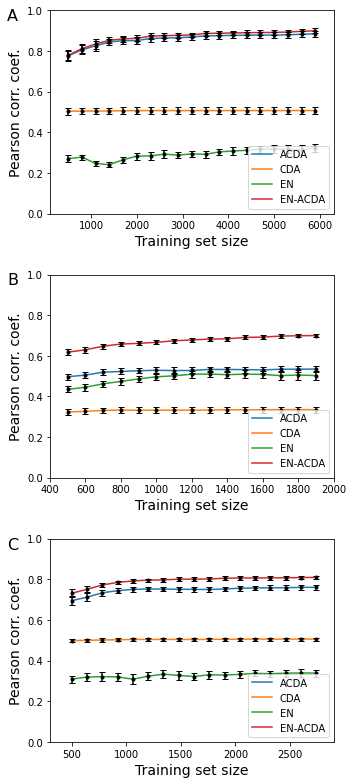

In [95]:
fig, ax = plt.subplots(3, 1, figsize=(5,11))
drawOneDownsampled(pd.read_csv('../output/downSample_4_breast_ASTRAZENECA_v2_9_5900.csv', index_col=[0,1,2]), ax[0], 'A', 500, 5900, 400, 1)
drawOneDownsampled(pd.read_csv('../output/downSample_4_lung_ASTRAZENECA_v2_9_1900.csv', index_col=[0,1,2]), ax[1], 'B', 500, 1900, 100, 1)
drawOneDownsampled(pd.read_csv('../output/downSample_4_urinary_tract_ASTRAZENECA_v2_9_2740.csv', index_col=[0,1,2]), ax[2], 'C', 500, 2700, 200, 1)
fig.tight_layout()
plt.subplots_adjust(hspace=0.3)
fig.savefig('downsampling_v2.png', dpi=600)
plt.show()

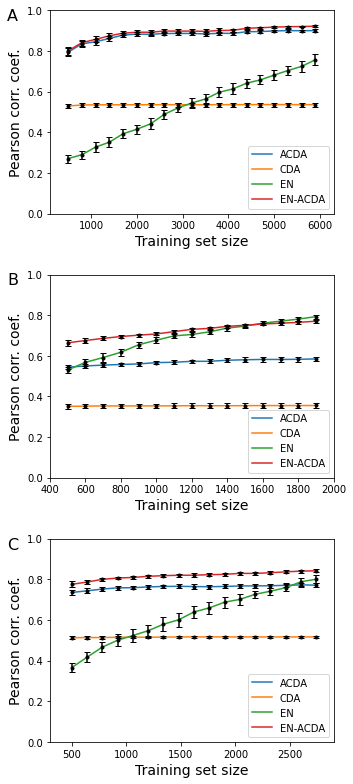

In [50]:
fig, ax = plt.subplots(3, 1, figsize=(5,11))
drawOneDownsampled(pd.read_csv('../output/downSample_4_breast_ASTRAZENECA_9_5900.csv', index_col=[0,1,2]), ax[0], 'A', 500, 5900, 400, 1)
drawOneDownsampled(pd.read_csv('../output/downSample_4_lung_ASTRAZENECA_9_1900.csv', index_col=[0,1,2]), ax[1], 'B', 500, 1900, 100, 1)
drawOneDownsampled(pd.read_csv('../output/downSample_4_urinary_tract_ASTRAZENECA_9_2740.csv', index_col=[0,1,2]), ax[2], 'C', 500, 2700, 200, 1)
fig.tight_layout()
plt.subplots_adjust(hspace=0.3)
fig.savefig('downsampling.png', dpi=600)
plt.show()

# Single datasets DrugComb

In [38]:
o = se_models_mutations_GDSC.index.intersection(df_DC.index.to_frame()['MODEL'].unique())
for_single = df_DC.loc[df_DC.index.to_frame()['MODEL'].isin(o)].index.to_frame()['STUDY'].groupby(level=['TISSUE', 'STUDY']).count()
for_single = for_single[for_single>1000].index
print(for_single.shape)

(19,)


In [39]:
(int(4382*2/3), int(4382*1/3)), (int(3510*2/3), int(3510*1/3)), (int(9878*2/3), int(9878*1/3)), 

((2921, 1460), (2340, 1170), (6585, 3292))

In [40]:
if False:
    for_single_datasets = dict()
    for tissue, study in for_single:
        print(tissue, '\t', study, end='\t')
        temp = prepareFromDCforCDA(df_DC, study, tissue, se_models_mutations_GDSC, sample=5*10**3)
        for_single_datasets.update({(tissue, study): temp})
        print(temp.shape)
else:
    for_single_datasets = dict()
    for tissue, study in for_single:
        if False:
            for_single_datasets[(tissue, study)].to_csv('../data/for_single_datasets_DC_%s_%s.csv.gz' % (tissue, study))
        else:
            for_single_datasets[(tissue, study)] = pd.read_csv('../data/for_single_datasets_DC_%s_%s.csv.gz' % (tissue, study), index_col=[0,1,2,3])

In [41]:
for tissue, study in for_single:
    fname = '../output/tested_results_single_i_DC_Cij_%s_%s_v2.pklz' % (tissue, study)
    if not os.path.isfile(fname):
        print(tissue, study)
        temp = MonteCarloCrossValidation(for_single_datasets[(tissue, study)], n=10, clf_for_CDA=LinearRegression())
        with open(fname, 'wb') as outfile:
            pickle.dump({(tissue, study): temp}, outfile)

In [42]:
tested_results_single_restored = dict()
for tissue, study in for_single:
    fname = '../output/tested_results_single_i_DC_Cij_%s_%s_v2.pklz' % (tissue, study)
    if os.path.isfile(fname):
        with open(fname, 'rb') as outfile:
            tested_results_single_restored.update(pickle.load(outfile))
            
ind = pd.MultiIndex.from_tuples(tested_results_single_restored.keys(), names=['TISSUE', 'STUDY'])
df_res_single = pd.concat([tested_results_single_restored[i][0].set_axis(['avg', 'sem'], axis=1) for i in ind], keys=ind, axis=1).T.unstack(-1).fillna(0)

print('Tissues:', df_res_single.reset_index()['TISSUE'].value_counts().shape[0])

df_res_single.style.background_gradient(axis=1)

Tissues: 10


In [54]:
df_temp = df_res_single.copy()
df_temp = df_temp[df_temp.columns[df_temp.columns.get_level_values(0).isin(['ACDA', 'EN', 'CDA'])]].xs('avg', level=1, axis=1)
df_temp['EN_is_better_than_ACDA'] = df_temp['EN'] > df_temp['ACDA']
df_temp['EN_is_better_than_CDA'] = df_temp['EN'] > df_temp['CDA']
df_temp['ACDA_is_better_than_CDA'] = df_temp['ACDA'] > df_temp['CDA']
# df_temp['percent_diff'] = 100 * 2 * np.abs(df_temp['EN'] - df_temp['ACDA']) / df_temp['EN'] + df_temp['ACDA']
print(len(df_temp), df_temp['EN_is_better_than_ACDA'].sum(), df_temp['EN_is_better_than_CDA'].sum())
df_temp.sort_values(by='EN_is_better_than_CDA')

19 4 14


ACDA    CDA     EN  \
TISSUE                      STUDY                              
urinary_tract               ASTRAZENECA  0.760  0.505  0.339   
brain                       FORCINA      0.345  0.432  0.000   
skin                        FRIEDMAN     0.846  0.819  0.730   
breast                      ASTRAZENECA  0.885  0.507  0.328   
haematopoietic_and_lymphoid NCATS_HL     0.960  0.881  0.467   
skin                        ALMANAC      0.568  0.310  0.496   
prostate                    ALMANAC      0.581  0.211  0.444   
ovary                       ONEIL        0.561  0.161  0.594   
                            ALMANAC      0.486  0.220  0.485   
lung                        ONEIL        0.458  0.098  0.521   
brain                       ALMANAC      0.613  0.256  0.477   
skin                        ONEIL        0.426  0.219  0.434   
large_intestine             ONEIL        0.365  0.233  0.459   
                            ALMANAC      0.580  0.332  0.483   
kidney                      ALMANAC      0.473  0.223  0.415   
haematopoietic_and_lymphoid ALMANAC      0.401  0.174  0.347   
breast                      ALMANAC      0.545  0.255  0.466   
lung                        ASTRAZENECA  0.539  0.335  0.505   
                            ALMANAC      0.434  0.180  0.408   

                                         EN_is_better_than_ACDA  \
TISSUE                      STUDY                                 
urinary_tract               ASTRAZENECA                   False   
brain                       FORCINA                       False   
skin                        FRIEDMAN                      False   
breast                      ASTRAZENECA                   False   
haematopoietic_and_lymphoid NCATS_HL                      False   
skin                        ALMANAC                       False   
prostate                    ALMANAC                       False   
ovary                       ONEIL                          True   
                            ALMANAC                       False   
lung                        ONEIL                          True   
brain                       ALMANAC                       False   
skin                        ONEIL                          True   
large_intestine             ONEIL                          True   
                            ALMANAC                       False   
kidney                      ALMANAC                       False   
haematopoietic_and_lymphoid ALMANAC                       False   
breast                      ALMANAC                       False   
lung                        ASTRAZENECA                   False   
                            ALMANAC                       False   

                                         EN_is_better_than_CDA  \
TISSUE                      STUDY                                
urinary_tract               ASTRAZENECA                  False   
brain                       FORCINA                      False   
skin                        FRIEDMAN                     False   
breast                      ASTRAZENECA                  False   
haematopoietic_and_lymphoid NCATS_HL                     False   
skin                        ALMANAC                       True   
prostate                    ALMANAC                       True   
ovary                       ONEIL                         True   
                            ALMANAC                       True   
lung                        ONEIL                         True   
brain                       ALMANAC                       True   
skin                        ONEIL                         True   
large_intestine             ONEIL                         True   
                            ALMANAC                       True   
kidney                      ALMANAC                       True   
haematopoietic_and_lymphoid ALMANAC                       True   
breast                      ALMANAC                       True   
lung                        ASTRAZE

In [44]:
mean_ACDA = np.round(np.mean(df_res_single.xs('ACDA', level=0, axis=1)['avg']), 3)
sem_ACDA =  np.round((df_res_single.xs( 'ACDA', level=0, axis=1)['avg']).sem(), 3)
mean_CDA =  np.round(np.mean(df_res_single.xs( 'CDA', level=0, axis=1)['avg']), 3)
sem_CDA =   np.round((df_res_single.xs(  'CDA', level=0, axis=1)['avg']).sem(), 3)
mean_EN =  np.round(np.mean(df_res_single.xs( 'EN', level=0, axis=1)['avg']), 3)
sem_EN =   np.round((df_res_single.xs(  'EN', level=0, axis=1)['avg']).sem(), 3)
mean_ENACDA =  np.round(np.mean(df_res_single.xs( 'EN-ACDA', level=0, axis=1)['avg']), 3)
sem_ENACDA =   np.round((df_res_single.xs(  'EN-ACDA', level=0, axis=1)['avg']).sem(), 3)

print('avg correlation ACDA:\t', mean_ACDA, '\t', sem_ACDA)
print('avg correlation CDA:\t', mean_CDA, '\t', sem_CDA)
print('avg correlation EN:\t', mean_EN, '\t', sem_EN)
print('avg correlation EN-ACD:\t', mean_ENACDA, '\t', sem_ENACDA)
print(100*np.round((mean_ACDA-mean_CDA)/mean_CDA, 2), '% increase')
print(100*np.round((mean_ENACDA-mean_CDA)/mean_CDA, 2), '% increase')

avg correlation ACDA:	 0.57 	 0.04
avg correlation CDA:	 0.334 	 0.049
avg correlation EN:	 0.442 	 0.032
avg correlation EN-ACD:	 0.645 	 0.036
71.0 % increase
93.0 % increase


In [45]:
df_res_single.xs('ASTRAZENECA', level='STUDY', drop_level=False).style.background_gradient(axis=1)

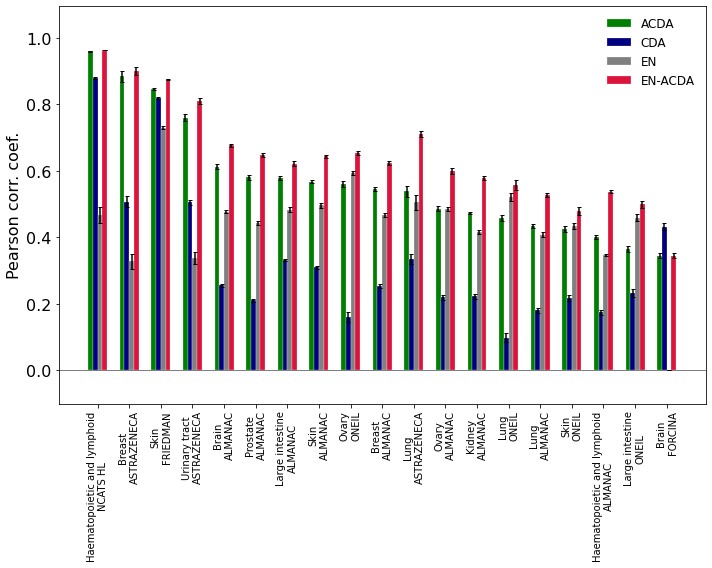

In [46]:
makeBarplotSingleDatasets(df_res_single.sort_values(by=('ACDA', 'avg'), ascending=False), figsize=(10, 8), saveName='barplot_single.png'); # 15 7

# Cross training DrugComb

In [44]:
o = se_models_mutations_GDSC.index.intersection(df_DC.index.to_frame()['MODEL'].unique())
df_DC_cut = df_DC.loc[df_DC.index.to_frame()['MODEL'].isin(o)]
for_cross_check = df_DC_cut.index.to_frame()['STUDY'].groupby(level=['TISSUE', 'STUDY']).count()
for_cross_check = for_cross_check.loc[[
            (                      'brain',     'ALMANAC'),
            (                      'brain',     'FORCINA'),
            (                     'breast',     'ALMANAC'),
            (                     'breast', 'ASTRAZENECA'),
            ('haematopoietic_and_lymphoid',     'ALMANAC'),
            ('haematopoietic_and_lymphoid',    'NCATS_HL'),
            (            'large_intestine',     'ALMANAC'),
            (            'large_intestine',       'ONEIL'),
            (                       'lung',     'ALMANAC'),
            (                       'lung', 'ASTRAZENECA'),
            (                       'lung',       'ONEIL'),
            (                      'ovary',     'ALMANAC'),
            (                      'ovary',       'ONEIL'),
            (                       'skin',     'ALMANAC'),
            (                       'skin',    'FRIEDMAN'),
            (                       'skin',       'ONEIL')]].index

In [45]:
cross_cases = []
for_cross_check_tissues = for_cross_check.get_level_values('TISSUE').unique().values.tolist()
print(for_cross_check_tissues)
for tissue in for_cross_check_tissues:
    studies = pd.Series(index=for_cross_check, dtype=object).xs(tissue, level='TISSUE').index.values
    cross_cases.append((tissue, studies[0], studies[1]))
    cross_cases.append((tissue, studies[1], studies[0]))
    if len(studies)==3:
        cross_cases.append((tissue, studies[0], studies[2]))
        cross_cases.append((tissue, studies[2], studies[0]))
        cross_cases.append((tissue, studies[1], studies[2]))
        cross_cases.append((tissue, studies[2], studies[1]))
print('Cases:', len(cross_cases))

['brain', 'breast', 'haematopoietic_and_lymphoid', 'large_intestine', 'lung', 'ovary', 'skin']
Cases: 22


In [50]:
tested_results_cross = dict()

for tissue, study1, study2 in cross_cases:
    fname = '../output/tested_results_cross_DC_i_Cij_%s_%s_%s_v2.pklz' % (tissue, study1, study2)
    if not os.path.isfile(fname):
        print(tissue, study1, study2)
        temp = trainOneTestAnother(for_single_datasets[(tissue, study1)], for_single_datasets[(tissue, study2)], n=10)
        tested_results_cross.update({(tissue, study1, study2): temp})
        with open(fname, 'wb') as outfile:
            pickle.dump({(tissue, study1, study2): tested_results_cross[(tissue, study1, study2)]}, outfile)
    else:
        with open(fname, 'rb') as outfile:
            tested_results_cross.update(pickle.load(outfile))
            
ind = pd.Index(tested_results_cross.keys(), names=['TISSUE', 'STUDY1', 'STUDY2'])
df_res_cross = pd.concat([tested_results_cross[i][0].set_axis(['avg', 'sem'], axis=1) for i in ind], keys=ind, axis=1).T.unstack(-1).fillna(0)
print(df_res_cross.shape)
df_res_cross.style.background_gradient(axis=1)

(22, 8)


C:\Users\domans\AppData\Local\Temp\ipykernel_1896\3743599561.py:15: FutureWarning:

Passing keywords other than 'data', 'dtype', 'copy', 'name', 'tupleize_cols' is deprecated and will raise TypeError in a future version.  Use the specific Index subclass directly instead.



In [51]:
print('Tissues:', df_res_cross.reset_index()['TISSUE'].value_counts().shape[0])
print('Datasets:', df_res_cross.reset_index()['STUDY1'].value_counts().shape[0])

Tissues: 7
Datasets: 6


In [53]:
df_res_cross.reset_index()['TISSUE'].value_counts()

lung                           6
skin                           6
brain                          2
breast                         2
haematopoietic_and_lymphoid    2
large_intestine                2
ovary                          2
Name: TISSUE, dtype: int64

In [48]:
print('mean correlation:', np.mean(df_res_cross.xs('ACDA', level=0, axis=1)['avg']), df_res_cross.xs('ACDA', level=0, axis=1)['avg'].sem())
print('mean correlation:', np.mean(df_res_cross.xs('CDA', level=0, axis=1)['avg']), df_res_cross.xs('CDA', level=0, axis=1)['avg'].sem())

mean_ACDA = np.round(np.mean(df_res_cross.xs('ACDA', level=0, axis=1)['avg']), 3)
sem_ACDA =  np.round((df_res_cross.xs( 'ACDA', level=0, axis=1)['avg']).sem(), 3)
mean_CDA =  np.round(np.mean(df_res_cross.xs( 'CDA', level=0, axis=1)['avg']), 3)
sem_CDA =   np.round((df_res_cross.xs(  'CDA', level=0, axis=1)['avg']).sem(), 3)
mean_EN =  np.round(np.mean(df_res_cross.xs( 'EN', level=0, axis=1)['avg']), 3)
sem_EN =   np.round((df_res_cross.xs(  'EN', level=0, axis=1)['avg']).sem(), 3)
mean_ENACDA =  np.round(np.mean(df_res_cross.xs( 'EN-ACDA', level=0, axis=1)['avg']), 3)
sem_ENACDA =   np.round((df_res_cross.xs(  'EN-ACDA', level=0, axis=1)['avg']).sem(), 3)

print('avg correlation ACDA:\t', mean_ACDA, '\t', sem_ACDA)
print('avg correlation CDA:\t', mean_CDA, '\t', sem_CDA)
print('avg correlation EN:\t', mean_EN, '\t', sem_EN)
print('avg correlation EN-ACD:\t', mean_ENACDA, '\t', sem_ENACDA)
print(100*np.round((mean_ACDA-mean_CDA)/mean_CDA, 2), '% increase')
print(100*np.round((mean_ENACDA-mean_CDA)/mean_CDA, 2), '% increase')

mean correlation: 0.22801363636363634 0.045731807726116236
mean correlation: 0.21515454545454543 0.05111064931148997
avg correlation ACDA:	 0.228 	 0.046
avg correlation CDA:	 0.215 	 0.051
avg correlation EN:	 0.009 	 0.012
avg correlation EN-ACD:	 0.233 	 0.049
6.0 % increase
8.0 % increase


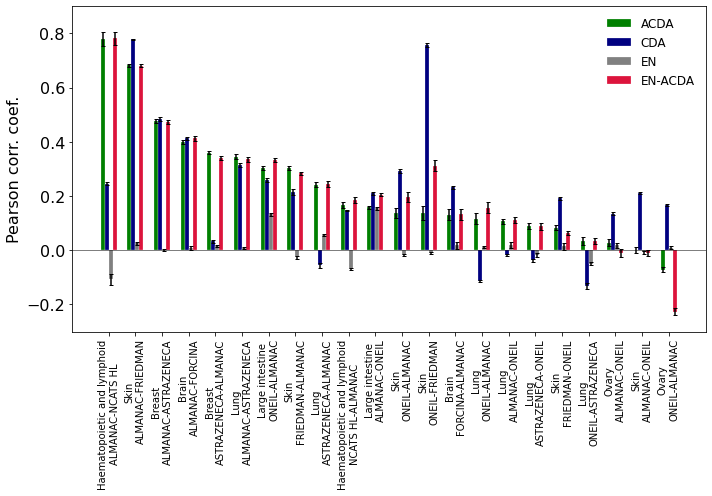

In [49]:
makeBarplotCrossDatasets(df_res_cross.sort_values(by=('ACDA', 'avg'), ascending=False), figsize=(10,7), saveName='barplot_cross.png');

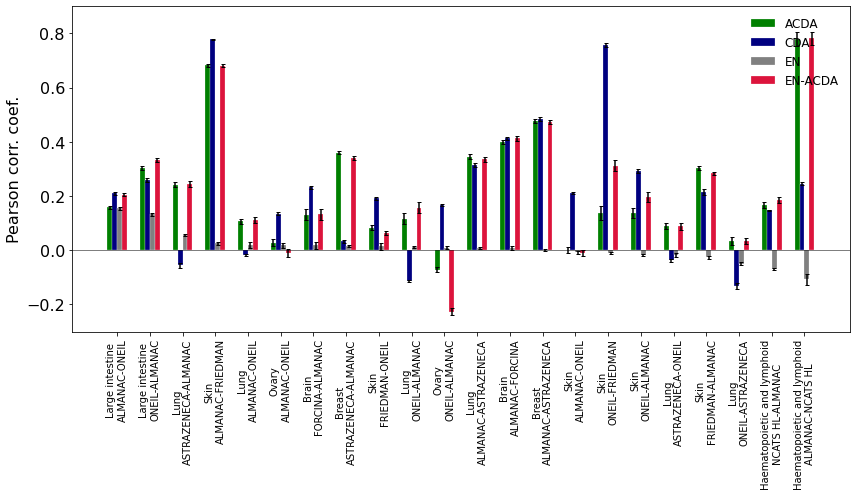

In [51]:
makeBarplotCrossDatasets(df_res_cross.sort_values(by=('EN', 'avg'), ascending=False), saveName='barplot_cross_EN.png');

# M on DC (>=1000 entries)

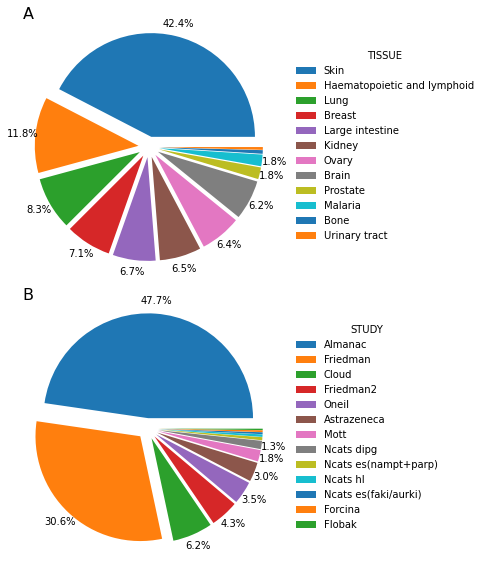

In [286]:
def plotCatPie(col, panel='', ax=None):
    se = df_DC.index.to_frame()[col].groupby(level=[col]).count().sort_values(ascending=False)
    se = se[se>=1000]

    def func(pct, allvals):
        if pct>=1:
            return "{:.1f}%".format(pct)
        else:
            return ''

    labels = se.index.values
    sizes = se.values
    explode = [0.1 for i in range(len(labels))]

    if ax is None:
        fig1, ax = plt.subplots(figsize=(6.5, 6))
        
    ax.pie(sizes, autopct=lambda pct: func(pct, sizes), explode=explode, labels=None, shadow=False, startangle=0, pctdistance=1.12) # , wedgeprops={'edgecolor': 'r'}
    ax.axis('equal')

    # ax.set_title(col)
    labels = pd.Series(se.index.values).str.capitalize().str.replace('_', ' ').values
    
    ax.legend(labels=labels, title=col, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), frameon=False)
    
    ax.text(ax.get_xlim()[0], ax.get_ylim()[1], panel , size=16)
    return

fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(6.8, 8))
plotCatPie('TISSUE', panel='A', ax=axs[0])
plotCatPie('STUDY', panel='B', ax=axs[1])
fig.tight_layout()
fig.savefig('pies.png', facecolor='w', dpi=450)

In [165]:
def runOneJson(args):  
    try:
        synergy, size, dataset, tissue, df_train_test, df_validate = args

        if not os.path.isfile('output/%s_%s_%s.json' % (dataset, tissue, synergy)):
            print(synergy, '\t', size, '\t', dataset, '\t', tissue)
            res = testCase(df_train_test, df_validate, encode=True, useAllFeatures=False, cv=None)
            res.update({'synergy': synergy, 'size': size, 'dataset': dataset, 'tissue': tissue})

            with open('output/%s_%s_%s.json' % (dataset, tissue, synergy), 'w') as outfile:
                json.dump(res, outfile)
    except Exception as exception:
        print('Exception:', exception)
    
    return

In [174]:
params = []
for dataset in df_DC.index.get_level_values('STUDY').unique()[:]:
    df_study = df_DC.xs(dataset, level='STUDY')
    for tissue in ['skin', 'breast', 'lung', 'haematopoietic_and_lymphoid', 'large_intestine', 'kidney', 'ovary', 'brain']: # df_study.index.get_level_values('TISSUE').unique()[:3]:
        try:
            df_study_tissue = df_study.xs(tissue, level='TISSUE')
            df_study_tissue = df_study_tissue.sample(min(3*10**3, df_study_tissue.shape[0]), random_state=0)
            for synergy in ['SYNERGY_ZIP', 'SYNERGY_LOEWE', 'SYNERGY_HSA', 'SYNERGY_BLISS'][:]:
                df_temp = df_study_tissue[[synergy]].copy()
                size = df_temp.shape[0]
                if size>=10**3:
                    #print(size, '\t', synergy, '\t', dataset, '\t', tissue)
                    df_temp = df_temp.rename({synergy: 'SYNERGY_SCORE'}, axis=1)
                    df_train_test = df_temp.sample(int(size*2/3), random_state=0)
                    df_validate = df_temp.loc[~df_temp.index.isin(df_train_test.index)]

                    params.append((synergy, size, dataset, tissue, df_train_test, df_validate))
        except Exception as exception:
            pass
        
print(len(params))

92


In [320]:
for p in params:
    runOneJson(p)
    
sparams = []

dfs = []
for p in params:
    synergy, size, dataset, tissue, df_train_test, df_validate = p
    
    try:
        with open('output/%s_%s_%s.json' % (dataset, tissue, synergy), 'r') as outfile:
            res = json.load(outfile) 
        dfs.append(res)
        sparams.append(p)
    except:
        pass
    
df_res = pd.DataFrame(dfs).sort_values(by='tissue')
df_res = df_res.drop(['self', 'cv_mean', 'cv_std', 'ro', 'size'], axis=1).dropna().rename({'val': 'correlation'}, axis=1)
print(df_res.tissue.value_counts())
df_res['tissue'] = df_res['tissue'].str.capitalize().str.replace('_', ' ')
df_res

SYNERGY_LOEWE 	 3000 	 FRIEDMAN 	 skin
Exception: could not convert string to float: '\\N'
haematopoietic_and_lymphoid    16
skin                           15
large_intestine                12
lung                           12
breast                         12
brain                           8
ovary                           8
kidney                          4
Name: tissue, dtype: int64


,correlation,synergy,dataset,tissue
31,0.277,SYNERGY_BLISS,ALMANAC,Brain
30,0.248,SYNERGY_HSA,ALMANAC,Brain
29,0.306,SYNERGY_LOEWE,ALMANAC,Brain
28,0.412,SYNERGY_ZIP,ALMANAC,Brain
62,0.052,SYNERGY_BLISS,NCATS_DIPG,Brain
...,...,...,...,...
74,0.454,SYNERGY_BLISS,ONEIL,Skin
73,0.397,SYNERGY_HSA,ONEIL,Skin
72,0.523,SYNERGY_LOEWE,ONEIL,Skin
58,0.487,SYNERGY_BLISS,FRIEDMAN2,Skin


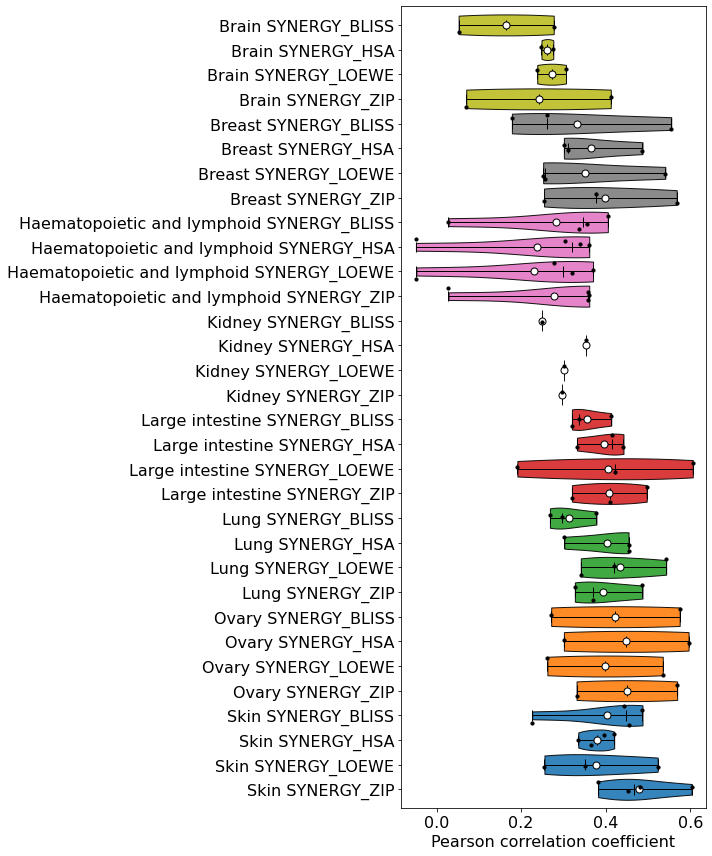

In [254]:
makeViolinPlot(df_res, ['correlation'], 'All', 'tissue|synergy', panelHeight=12, panelWidth=10, xlabel='Pearson correlation coefficient', ylabel='', title='', cmap=cm.tab10, showFractions=False, fontsize=16, pointsSize=10, pointsAlpha=1, pointsPushBack=False, excludeZeroValues=False, colorFactor=4)

In [336]:
dfsel = df_DC.reset_index()[['STUDY', 'TISSUE']]

makeSankeyDiagram(getCountsDataframe(dfsel['TISSUE'], dfsel['STUDY']), width=600, height=600)

Using default node colors


In [337]:
dfsel = df_DC.loc[(df_DC.index.get_level_values('STUDY').isin([p[2] for p in sparams])) & (df_DC.index.get_level_values('TISSUE').isin([p[3] for p in sparams]))].reset_index()[['STUDY', 'TISSUE']]

makeSankeyDiagram(getCountsDataframe(dfsel['TISSUE'], dfsel['STUDY']), width=575)

Using default node colors


# Simulation AUC vs Pearson

In [621]:
from sklearn.metrics import roc_auc_score, f1_score

In [622]:
np.random.seed(2)
N = 10000
M = 8000

def f(M):
    y_true = np.random.choice([0, 1], N, p=[0.2,0.8])
    y_pred = y_true.copy()
    wh = np.sort(np.random.choice(range(N), M, replace=False))
    y_pred[wh] = np.random.choice([0, 1], M)
    return {'AUC': roc_auc_score(y_true, y_pred), 'F1': f1_score(y_true, y_pred), 'Pearson': pearsonr(y_true, y_pred)[0]}

resm = dict()
for M in range(10**2, 10**4, 10**1):
    resm.update({M: f(M)})

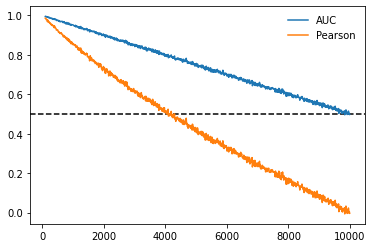

In [641]:
dftemp = pd.DataFrame(resm).T
dftemp['Pearson scaled'] = dftemp['Pearson']/2 + 0.5
dftemp[['AUC', 'Pearson']].plot()
plt.axhline(0.5, linestyle='--', color='k', zorder=-1)
# plt.xlim(0, 10**4)
# plt.ylim(0, 1)
plt.legend(frameon=False)

### Run RandomizedSearchCV

In [124]:
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

clf = RandomForestClassifier(random_state=0, max_depth=20, n_estimators=300)
rf_random = RandomizedSearchCV(estimator=clf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

index = df_train_test.index
inSynergy = (df_train_test.loc[index]['SYNERGY_SCORE']>=synergy_cutoff).astype(float).values
inData = df_train_test.loc[index][L].astype(float).copy()

rf_random.fit(inData, inSynergy)

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(max_depth=20,
                                                    n_estimators=300,
                                                    random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]}

### Evaluate RandomSearchCV findings

In [129]:
inSynergyV = (df_validate['SYNERGY_SCORE']>=synergy_cutoff).astype(float).values
inDataV = df_validate[L].astype(float).copy()

In [151]:
def evaluate(model, test_features, test_labels):
    accuracy = accuracy_score(test_labels, model.predict(test_features))
    f1score = f1_score(test_labels, model.predict(test_features))
    print('Accuracy = {:0.2f}%.'.format(100 * accuracy))
    print('F1 score = {:0.2f}%.'.format(100 * f1score))
    return accuracy

base_model = RandomForestClassifier(n_estimators=500, random_state=42)
base_model.fit(inData, inSynergy)
base_accuracy = evaluate(base_model, inDataV, inSynergyV)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, inDataV, inSynergyV)
print('Improvement of {:0.2f}%.'.format(100 * (random_accuracy - base_accuracy) / base_accuracy))

Accuracy = 77.76%.
F1 score = 32.15%.
Accuracy = 79.57%.
F1 score = 16.47%.
Improvement of 2.33%.


### Run GridSearchCV

In [148]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20],
    'max_features': [2, 3],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [750, 1000]
}
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(inData, inSynergy)
grid_search.best_params_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 750}

In [153]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, inDataV, inSynergyV)
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Accuracy = 79.57%.
F1 score = 16.33%.
Improvement of 2.33%.


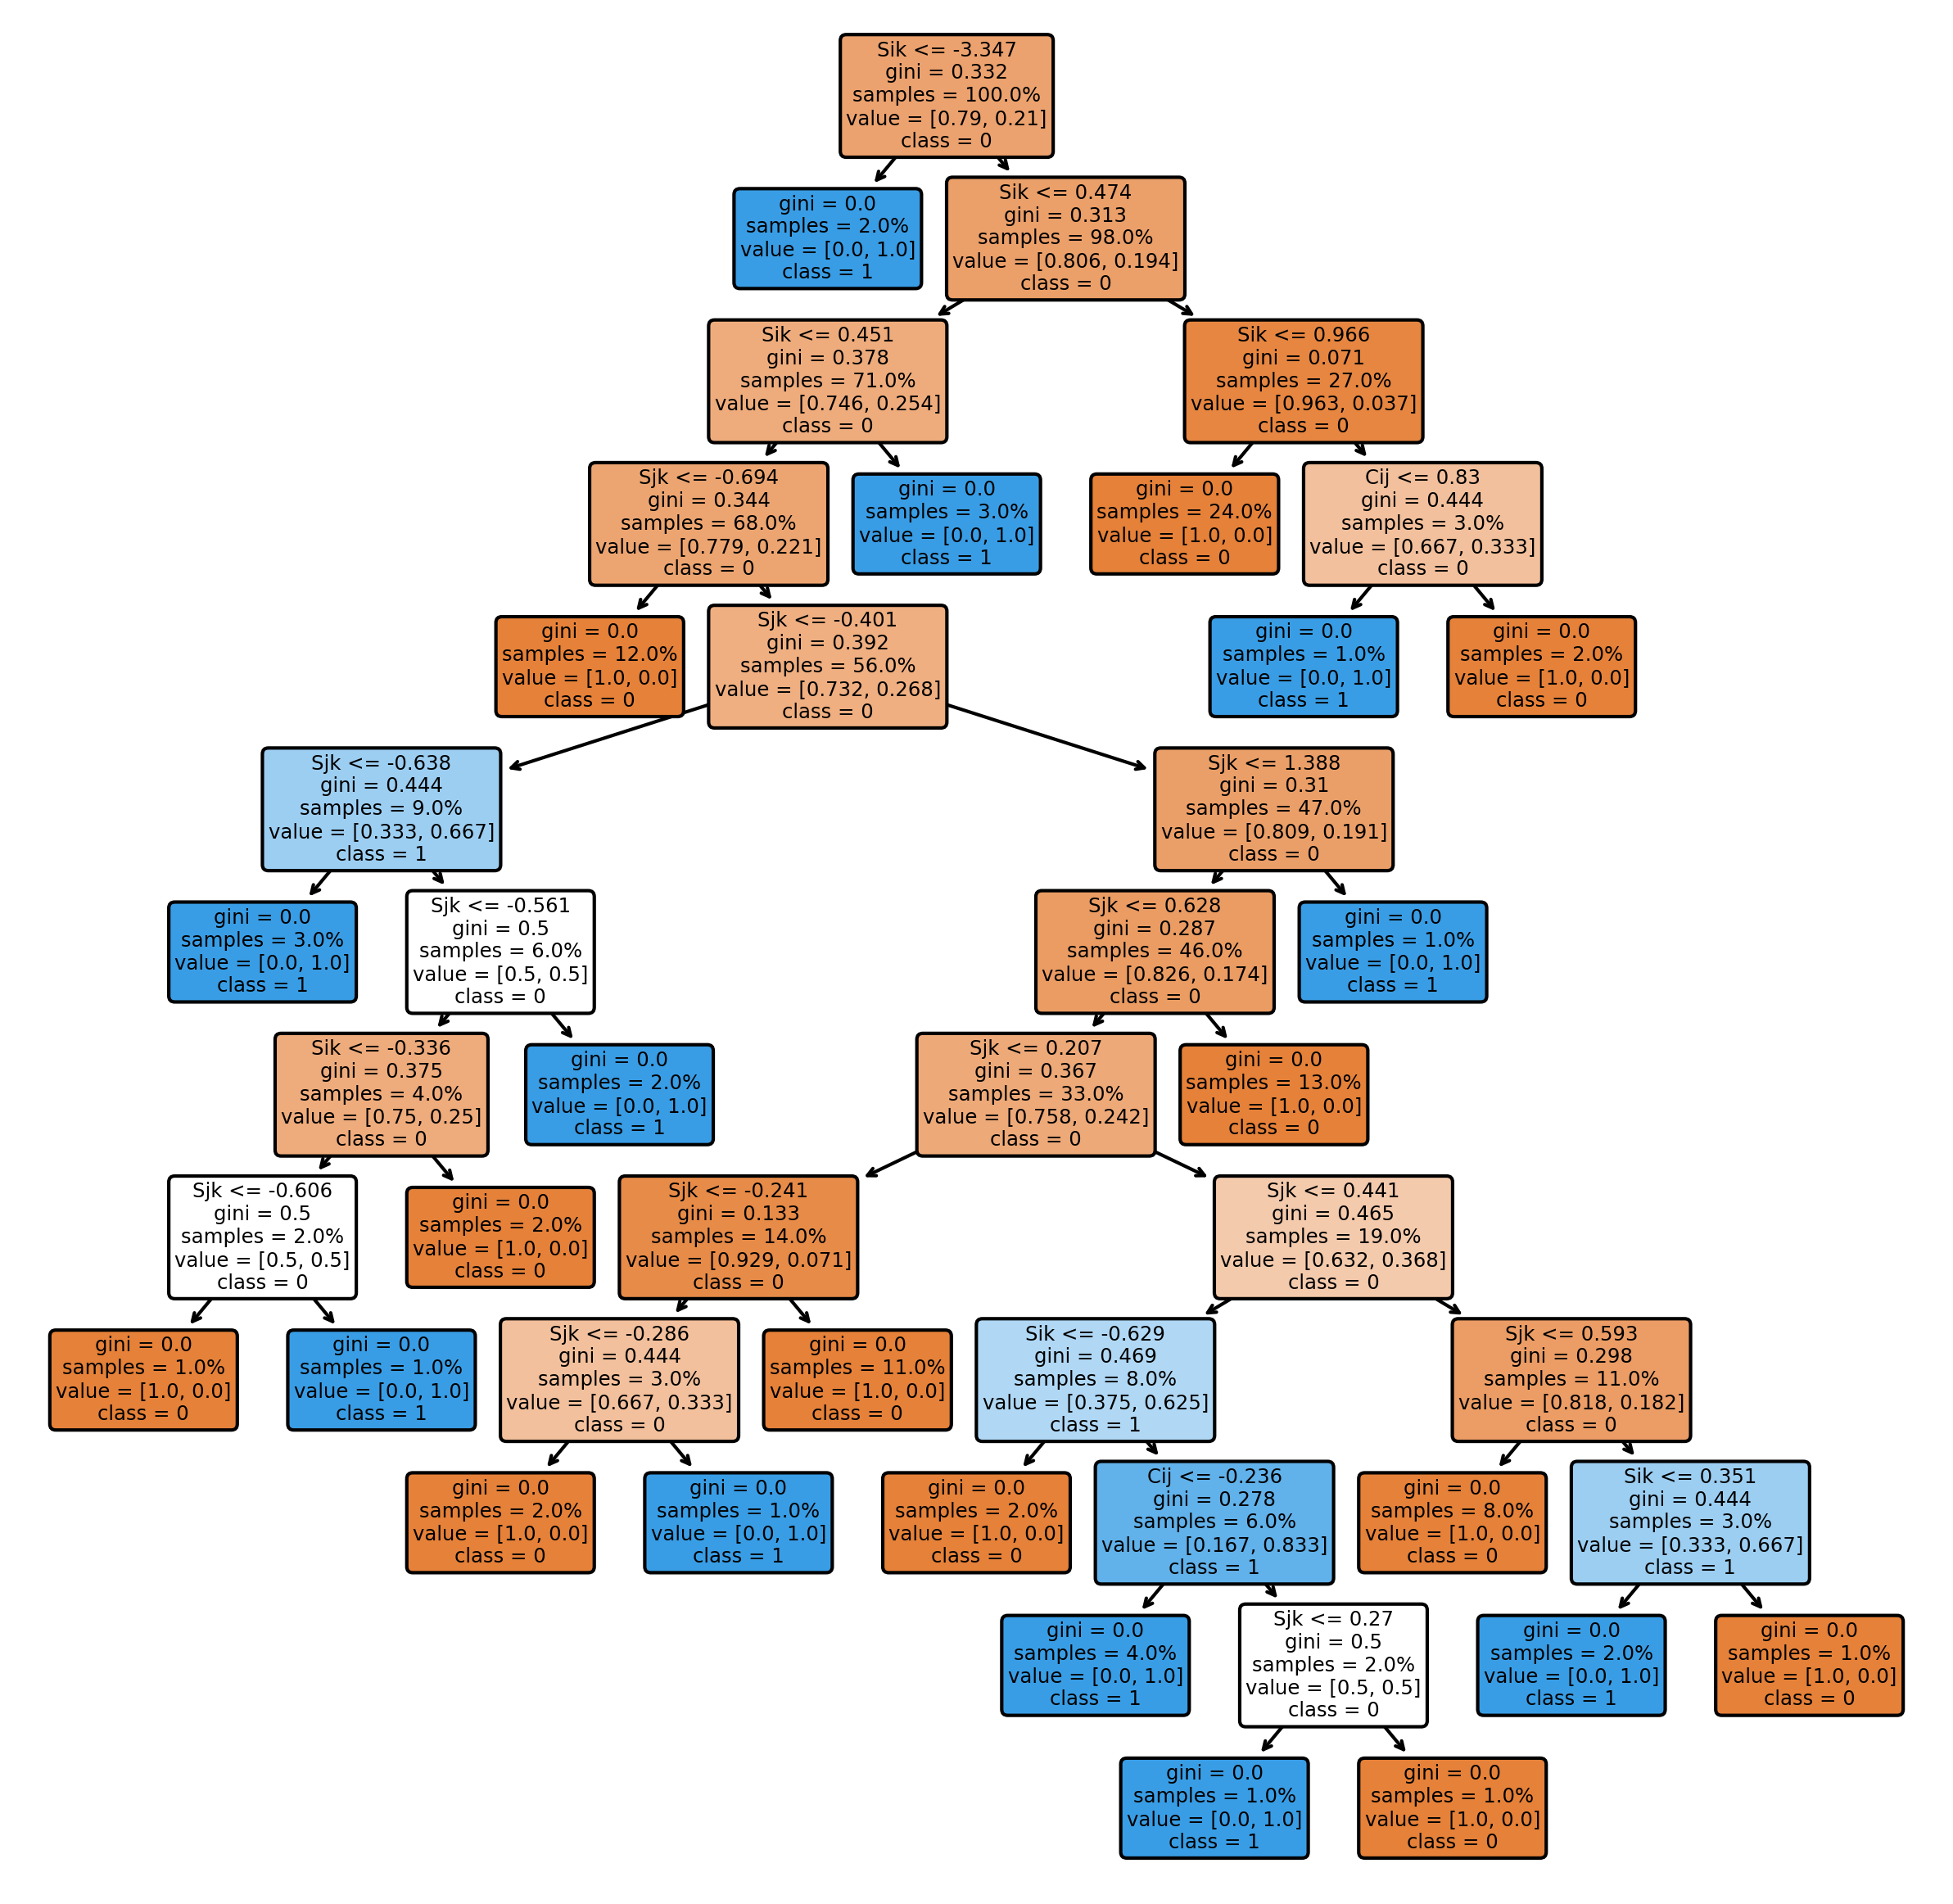

In [104]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10), dpi=300)
tree.plot_tree(clf, ax=ax, feature_names=L, class_names=['0', '1'], filled=True, proportion=True, rounded=True);

# Visualization

In [210]:
df_AZ_DC, dfC_AZ_DC, dfS_AZ_DC, Z_AZ_DC = prepareFromDCforCDA(df_DC, 'ASTRAZENECA', 'breast', se_models_mutations_GDSC, sample=None, returnMore=True) # symmetrized already
df_AZ_DC

SYNERGY_SCORE   Tijk        Cij  \
MODEL    DRUG1        DRUG2       TISSUE                                    
BT-20    001, RAD     AZD2014     breast      -3.872081  False   1.264700   
                      AZD5363     breast      -4.898580   True   1.993502   
         1309805-49-9 957054-30-7 breast      -1.593924   True  23.081317   
                      AZD2014     breast       0.701124  False  23.081317   
                      AZD4320     breast      -5.567694  False  23.081317   
...                                                 ...    ...        ...   
UACC-812 Trametinib   Vandetanib  breast       9.704949   True  31.722816   
         Vorinostat   Vandetanib  breast      -4.680860   True  19.597974   
         XL765        Vandetanib  breast       6.324694   True   8.553635   
         chloroquine  Vandetanib  breast      -1.543899   True  19.597974   
         tamoxifen    Vandetanib  breast       1.339240   True  31.722816   

                                             Sik     Sjk  
MODEL    DRUG1        DRUG2       TISSUE                  
BT-20    001, RAD     AZD2014     breast  40.432  37.158  
                      AZD5363     breast  40.875  25.159  
         1309805-49-9 957054-30-7 breast  18.645  22.490  
                      AZD2014     breast  19.110  20.853  
                      AZD4320     breast  16.292   8.926  
...                                          ...     ...  
UACC-812 Trametinib   Vandetanib  breast  85.625  25.498  
         Vorinostat   Vandetanib  breast  11.160  30.562  
         XL765        Vandetanib  breast  -5.804  18.490  
         chloroquine  Vandetanib  breast   3.707  25.227  
         tamoxifen    Vandetanib  breast   3.476  30.871  

[12606 rows x 5 columns]

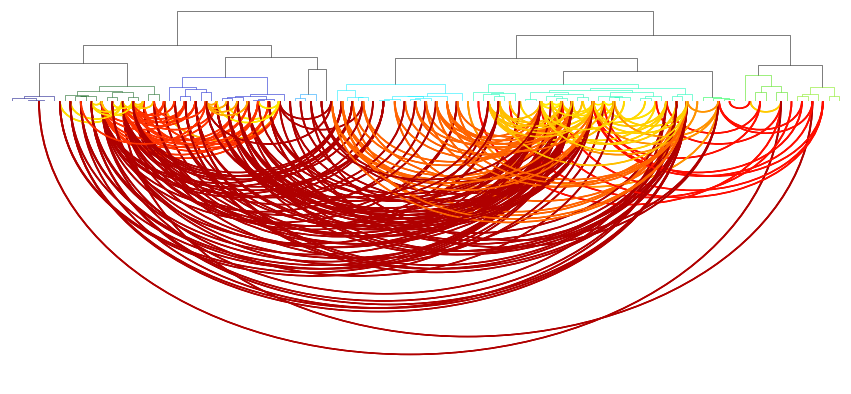

In [212]:
temp = df_AZ_DC['SYNERGY_SCORE'].droplevel(['MODEL', 'TISSUE'])
plotDendrogramWithKnownPairs(Z_AZ_DC, dfC_AZ_DC, temp[temp>=20].index.unique());

In [213]:
df_G2, dfC_G2, dfS_G2, Z_G2 = makeCDAformattedData('Breast', se_drug_synergy_Narayan, se_tissue_annotation_GDSC, df_drug_sensitivity_GDSC2, se_models_mutations_GDSC, se_drug_targets_GDSC, 'GDSC2', returnMore=True)
df_G2

Loading from cache...
803 cell lines, 34969 drug pairs
Synergy pairs in:	 874
Synergy pairs out:	 134
Data size: 28080107
0 1 2 
With known synergy: 74
With unknown synergy: 1783345


SYNERGY_SCORE   Tijk        Cij  \
MODEL    DRUG1       DRUG2       TISSUE                                    
AU565    foretinib   lapatinib   Breast            1.0  False  12.623131   
         lapatinib   foretinib   Breast            1.0  False  12.623131   
BT-20    gemcitabine mk-1775     Breast            1.0  False  18.986004   
         mk-1775     gemcitabine Breast            1.0  False  18.986004   
BT-474   azd8055     luminespib  Breast            1.0  False  50.876669   
...                                                ...    ...        ...   
ZR-75-30 zoledronate wz4003      Breast            NaN  False   0.657754   
                     xav939      Breast            NaN  False   4.253106   
                     yk-4-279    Breast            NaN  False  12.623131   
                     zm447439    Breast            NaN  False   7.727402   
                     zoledronate Breast            NaN  False   0.000000   

                                              Sik       Sjk  
MODEL    DRUG1       DRUG2       TISSUE                      
AU565    foretinib   lapatinib   Breast  1.080738 -0.819400  
         lapatinib   foretinib   Breast -0.819400  1.080738  
BT-20    gemcitabine mk-1775     Breast  2.930021  1.921266  
         mk-1775     gemcitabine Breast  1.921266  2.930021  
BT-474   azd8055     luminespib  Breast  1.047488 -1.770203  
...                                           ...       ...  
ZR-75-30 zoledronate wz4003      Breast  5.101493  5.864494  
                     xav939      Breast  5.101493  5.534174  
                     yk-4-279    Breast  5.101493  6.484139  
                     zm447439    Breast  5.101493  4.432672  
                     zoledronate Breast  5.101493  5.101493  

[1783419 rows x 5 columns]

In [214]:
def temp_get_predicted(df_G2, random_state):
    df_copy = df_G2.copy()
    df_copy = df_copy.loc[~df_copy[['Tijk', 'Cij', 'Sik', 'Sjk']].isna().any(axis=1)]
    df_copy.loc[df_copy[df_copy['SYNERGY_SCORE'].isna()].sample(100, random_state=random_state).index, 'SYNERGY_SCORE'] = 0.
    df_train_test = df_copy[~df_copy['SYNERGY_SCORE'].isna()]

    df_validate = df_copy[df_copy['SYNERGY_SCORE'].isna()]
    df_validate

    clf = fit_validate_predict(df_train_test[['Tijk', 'Cij', 'Sik', 'Sjk']].values, df_train_test['SYNERGY_SCORE'].values, cv=None, clf=None)

    se_predicted = pd.Series(index=df_validate.index, data=clf.predict(df_validate[['Tijk', 'Cij', 'Sik', 'Sjk']].values))
    return se_predicted

se_predicted = pd.concat([temp_get_predicted(df_G2, i) for i in range(10)], axis=1)
se_predicted = se_predicted.unstack(0).groupby(level=1, axis=1).agg(np.nanmean).stack().reorder_levels([3, 0, 1, 2]).sort_index()
se_predicted

On self:		 0.96557
On self:		 0.96361
On self:		 0.9692
On self:		 0.96949
On self:		 0.96464
On self:		 0.9674
On self:		 0.96744
On self:		 0.97199
On self:		 0.97161
On self:		 0.96715


MODEL     DRUG1           DRUG2           TISSUE
AU565     5-fluorouracil  5-fluorouracil  Breast    0.3704
                          abt737          Breast    0.1336
                          afatinib        Breast    0.3036
                          afuresertib     Breast    0.4128
                          agi-5198        Breast    0.0748
                                                     ...  
ZR-75-30  zoledronate     wz4003          Breast    0.0592
                          xav939          Breast    0.0000
                          yk-4-279        Breast    0.0000
                          zm447439        Breast    0.0024
                          zoledronate     Breast    0.0264
Length: 1460155, dtype: float64

DRUG,jq1,azd6482,gsk269962a,zm447439,ro-3306,nu7441,axitinib,tozasertib,ku-55933,pf-4708671,...,docetaxel,eg5_9814,dinaciclib,rapamycin,daporinad,mg-132,staurosporine,dactinomycin,sepantronium bromide,bortezomib
DRUG,,,,,,,,,,,,,,,,,,,,,
bortezomib,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sepantronium bromide,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dactinomycin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
staurosporine,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mg-132,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ro-3306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zm447439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gsk269962a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


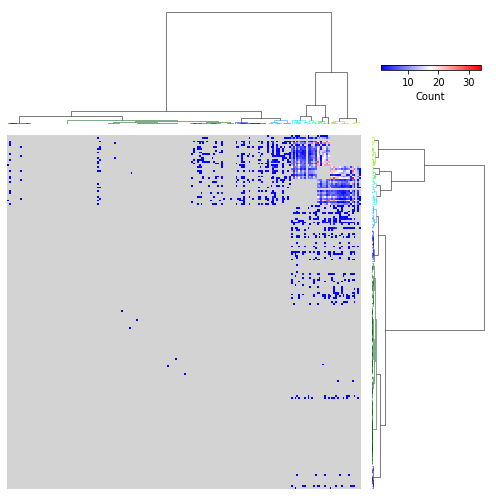

In [216]:
plotHeatmapPredictedSynergy(dfC_G2, Z_G2, se_predicted[se_predicted>=0.95].index.droplevel(-1).values)

DRUG,jq1,azd6482,gsk269962a,zm447439,ro-3306,nu7441,axitinib,tozasertib,ku-55933,pf-4708671,...,docetaxel,eg5_9814,dinaciclib,rapamycin,daporinad,mg-132,staurosporine,dactinomycin,sepantronium bromide,bortezomib
DRUG,,,,,,,,,,,,,,,,,,,,,
bortezomib,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sepantronium bromide,4.0,3.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dactinomycin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
staurosporine,4.0,4.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mg-132,6.0,3.0,1.0,1.0,1.0,2.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ro-3306,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
zm447439,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
gsk269962a,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,...,NaN,2.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN


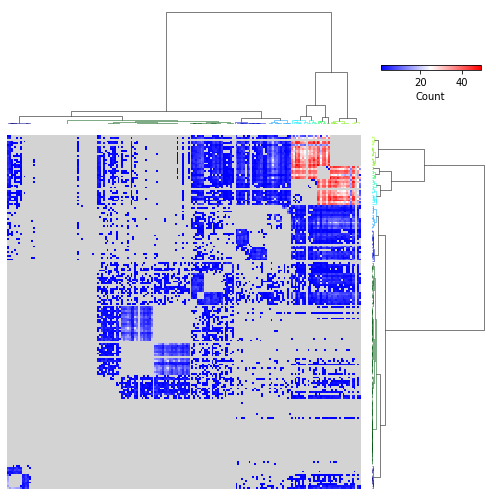

In [217]:
plotHeatmapPredictedSynergy(dfC_G2, Z_G2, se_predicted[se_predicted>=0.75].index.droplevel(-1).values)